# Projet 7 : Implémentez un modèle de scoring
##Modélisation et Suivi par MLFlow

###1.Introduction MLFlow

MLflow est une plate-forme open source polyvalente et extensible pour la gestion des flux de travail et des artefacts tout au long du cycle de vie de l'apprentissage automatique. Il a des intégrations intégrées avec de nombreuses bibliothèques ML populaires, mais peut être utilisé avec n'importe quelle bibliothèque, algorithme ou outil de déploiement. Il est conçu pour être extensible, vous pouvez donc écrire des plugins pour prendre en charge de nouveaux workflows, bibliothèques et outils.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

# Chemin vers ton dossier dans Drive
mlflow_path = "/content/drive/MyDrive/mlflow_logs"

# Crée le dossier s'il n'existe pas
os.makedirs(mlflow_path, exist_ok=True)

# Définit l’URI de tracking
os.environ['MLFLOW_TRACKING_URI'] = f"file:{mlflow_path}"


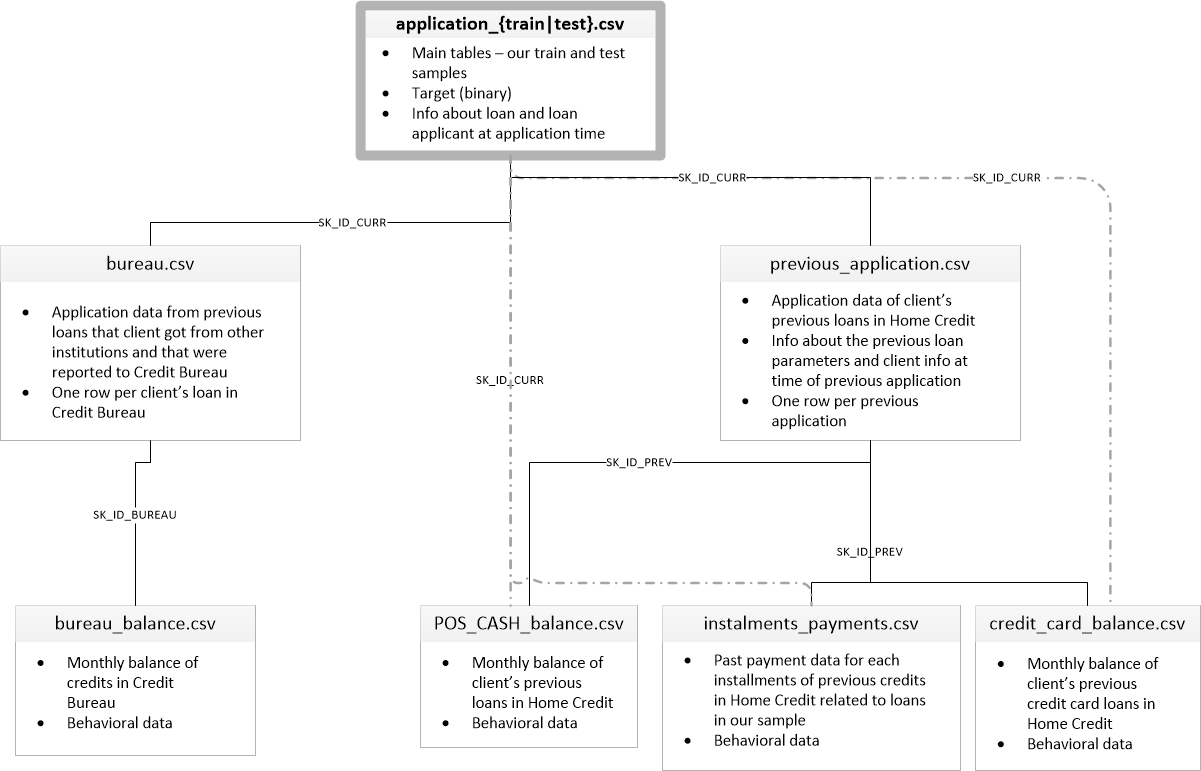

In [ ]:
from IPython import display
display.Image(r"/content/drive/MyDrive/home_credit.png")

**MLflow est utilisé pour gérer le cycle de vie de l'apprentissage automatique, du développement initial du modèle au déploiement et au-delà jusqu'à l'extinction. **

Il combine :

1 - Suivi des expériences ML pour enregistrer et comparer les paramètres du modèle, évaluer les performances et gérer les artefacts (MLflow Tracking)

2 - Conditionnement du code ML sous une forme réutilisable et reproductible afin de le partager avec d'autres data scientists ou de le transférer en production (MLflow Projects)

3 - Empaqueter et déployer des modèles à partir d'une variété de bibliothèques ML vers une variété de plates-formes de service et d'inférence de modèles (modèles MLflow)

4 - Gestion collaborative d'un magasin de modèles central, y compris la gestion des versions des modèles, les transitions d'étape et les annotations (MLflow Registry)

5 - Accélération du développement itératif avec des modèles et des scripts réutilisables pour une variété de tâches de modélisation courantes (MLflow Recipes)





In [3]:
#Basic libraries
import pandas as pd
import seaborn as sns
import time, pickle
import numpy as np
from zipfile import ZipFile
import matplotlib.pyplot as plt

In [4]:
#Metrics and models MLFLOW
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score

In [5]:
#Preprocessing, Upsampling, Model Selection, Model Evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, cross_validate
from sklearn.feature_selection import RFECV

## 1. Lecture des données

In [6]:
#Reading the dataset
data_train_csv = pd.read_csv('/content/drive/MyDrive/data_train_sans_valeurs_manquantes.csv', index_col='SK_ID_CURR', encoding ='utf-8')
data_train=data_train_csv.copy()
data_train.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,0.0,0.001512,0.090287,0.090032,0.077441,0.256321,0.111161,0.964437,0.852140,0.705433,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
100003,0.0,0.002089,0.311736,0.132924,0.271605,0.045016,0.522886,0.933676,0.951929,0.959566,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
100004,0.0,0.000358,0.022472,0.020025,0.023569,0.134897,0.651466,0.987439,0.827335,0.648326,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100006,0.0,0.000935,0.066837,0.109477,0.063973,0.107023,0.649154,0.830337,0.601451,0.661387,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100007,0.0,0.000819,0.116854,0.078975,0.117845,0.392880,0.701409,0.830393,0.825268,0.519522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
data_train.shape

(307511, 312)

In [8]:
TARGET_csv=pd.read_csv('/content/drive/MyDrive/TARGET.csv',index_col='SK_ID_CURR')
TARGET=TARGET_csv.copy()
TARGET.head()

,TARGET
SK_ID_CURR,
100002,1.0
100003,0.0
100004,0.0
100006,0.0
100007,0.0


In [ ]:
TARGET.shape

(307511, 1)

In [9]:
final_data=pd.concat([data_train, TARGET], axis=1, join='inner')
final_data.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,0.0,0.001512,0.090287,0.090032,0.077441,0.256321,0.111161,0.964437,0.852140,0.705433,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
100003,0.0,0.002089,0.311736,0.132924,0.271605,0.045016,0.522886,0.933676,0.951929,0.959566,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
100004,0.0,0.000358,0.022472,0.020025,0.023569,0.134897,0.651466,0.987439,0.827335,0.648326,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100006,0.0,0.000935,0.066837,0.109477,0.063973,0.107023,0.649154,0.830337,0.601451,0.661387,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100007,0.0,0.000819,0.116854,0.078975,0.117845,0.392880,0.701409,0.830393,0.825268,0.519522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##2. Splitting des données

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data_train.values, TARGET.values, test_size=0.3, random_state=42,stratify=TARGET.values)

In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((215257, 312), (92254, 312), (215257, 1), (92254, 1))

## 3. Baseline Model

Le projet consiste à mieux comprendre le défaut de crédit rencontré chez certain client, l'anticiper, l'estimer, etc… La prédiction peut se résumer par une sortie binaire, une acceptation de crédit, ou un refus de crédit. Afin d'avoir une première idée des performances possibles, la modélisation par régression logistique permettra d'obtenir une baseline.

In [13]:
pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 84.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 121.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 700.2/700.2 kB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.4 MB/s eta 0:00:00


In [14]:
import mlflow
import mlflow.sklearn

In [15]:
def eval_metrics(actual,pred):
    rmse=np.sqrt(mean_squared_error(actual,pred))
    mae=mean_absolute_error(actual,pred)
    r2=r2_score(actual,pred)
    return rmse, mae, r2

In [16]:
def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba, feature_importances,roc_auc):
    '''This function will make a pretty plot of
  an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    fig = plt.figure(figsize=(20,15))

    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    if feature_importances :
        plt.subplot(212)
        indices = np.argsort(model.feature_importances_)[::-1]

    plt.show()

In [17]:
mlflow.set_experiment('Log-Regression')

<Experiment: artifact_location='file:///content/drive/MyDrive/mlflow_logs/170809780774492976', creation_time=1746387253788, experiment_id='170809780774492976', last_update_time=1746387253788, lifecycle_stage='active', name='Log-Regression', tags={}>

In [18]:
#MLFLow Model function Linear Regression
def train_lr_model(C,max_iter,data):

    with mlflow.start_run():

        lr = LogisticRegression(C=C,max_iter=max_iter)
        lr.fit(X_train,y_train)

        predicted_qualities=lr.predict(X_test)

        (rmse,mae,r2)=eval_metrics(y_test,predicted_qualities)
        print("ElasticNet model (C=%f,max_iter=%f):" % (C,max_iter))
        print(" RMSE: %s" % rmse)
        print(" MAE:%s" % mae)
        print(" R2:%s" % r2)

        roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
        print('AUC : %0.4f' %roc_auc)
        print(classification_report(y_test, lr.predict(X_test)))
        cf_matrix_roc_auc(lr, y_test, lr.predict(X_test), lr.predict_proba(X_test)[:,1], feature_importances=None,roc_auc=roc_auc)

        mlflow.log_param("C",C)
        mlflow.log_param("max_iter",max_iter)
        mlflow.log_metric("rmse",rmse)
        mlflow.log_metric("r2",r2)
        mlflow.log_metric("mae",mae)
        mlflow.log_metric("AUC",roc_auc)

        mlflow.sklearn.log_model(lr,"model")

In [19]:
from sklearn.linear_model import LogisticRegression

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ElasticNet model (C=0.001000,max_iter=100.000000):
 RMSE: 0.2841366339038534
 MAE:0.08073362672621241
 R2:-0.08782397471876968
AUC : 0.7373
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84806
         1.0       0.00      0.00      0.00      7448

    accuracy                           0.92     92254
   macro avg       0.46      0.50      0.48     92254
weighted avg       0.85      0.92      0.88     92254



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


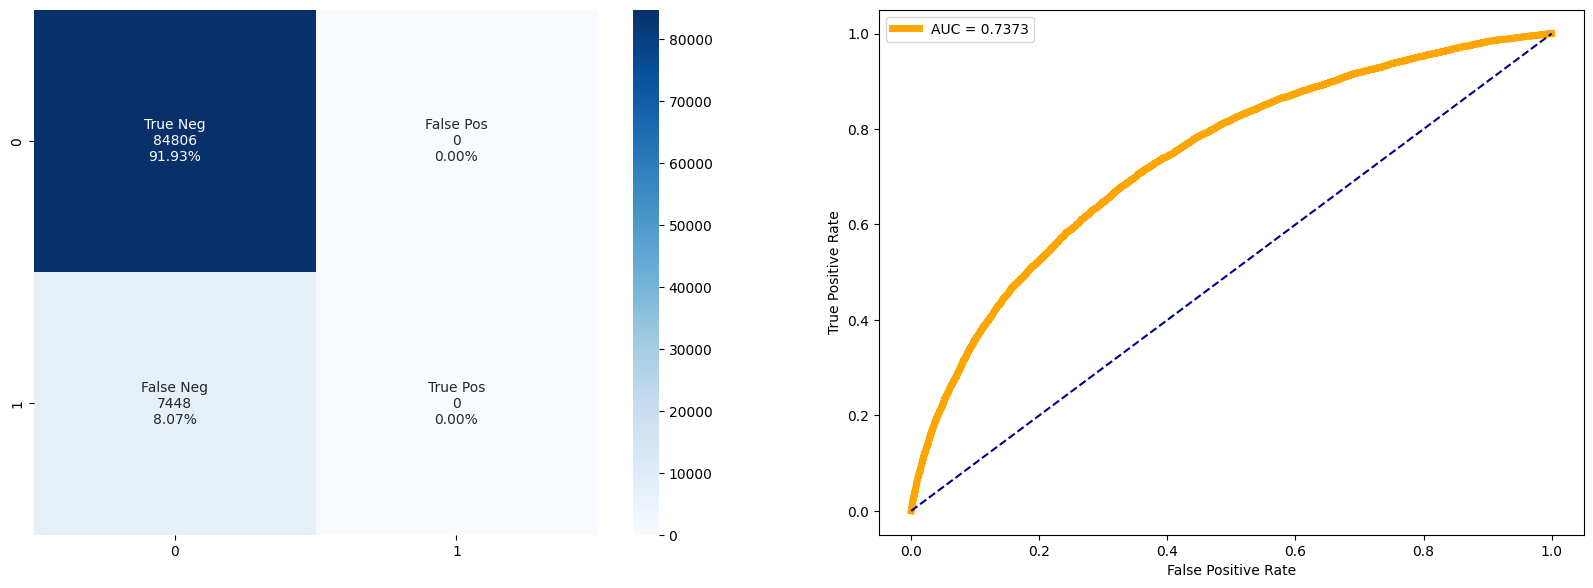

2025/05/06 09:28:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [20]:
train_lr_model(0.001,100,final_data)

In [22]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, roc_auc_score
import mlflow
import mlflow.sklearn

def train_dummy_model(strategy, data):

    with mlflow.start_run():

        dummy = DummyClassifier(strategy=strategy)
        dummy.fit(X_train, y_train)

        y_pred = dummy.predict(X_test)
        y_proba = dummy.predict_proba(X_test)[:, 1] if hasattr(dummy, "predict_proba") else None

        (rmse, mae, r2) = eval_metrics(y_test, y_pred)
        print("DummyClassifier (strategy=%s):" % strategy)
        print(" RMSE: %s" % rmse)
        print(" MAE: %s" % mae)
        print(" R2: %s" % r2)

        if y_proba is not None:
            roc_auc = roc_auc_score(y_test, y_proba)
            print('AUC : %0.4f' % roc_auc)
        else:
            roc_auc = None
            print("AUC: N/A (predict_proba not available for this strategy)")

        print(classification_report(y_test, y_pred))

        cf_matrix_roc_auc(dummy, y_test, y_pred, y_proba, feature_importances=None, roc_auc=roc_auc)

        mlflow.log_param("strategy", strategy)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)
        if roc_auc is not None:
            mlflow.log_metric("AUC", roc_auc)

        mlflow.sklearn.log_model(dummy, "dummy_model")


DummyClassifier (strategy=stratified):
 RMSE: 0.3850373154064749
 MAE: 0.14825373425542523
 R2: -0.9976058676461619
AUC : 0.5006
              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92     84806
         1.0       0.08      0.08      0.08      7448

    accuracy                           0.85     92254
   macro avg       0.50      0.50      0.50     92254
weighted avg       0.85      0.85      0.85     92254



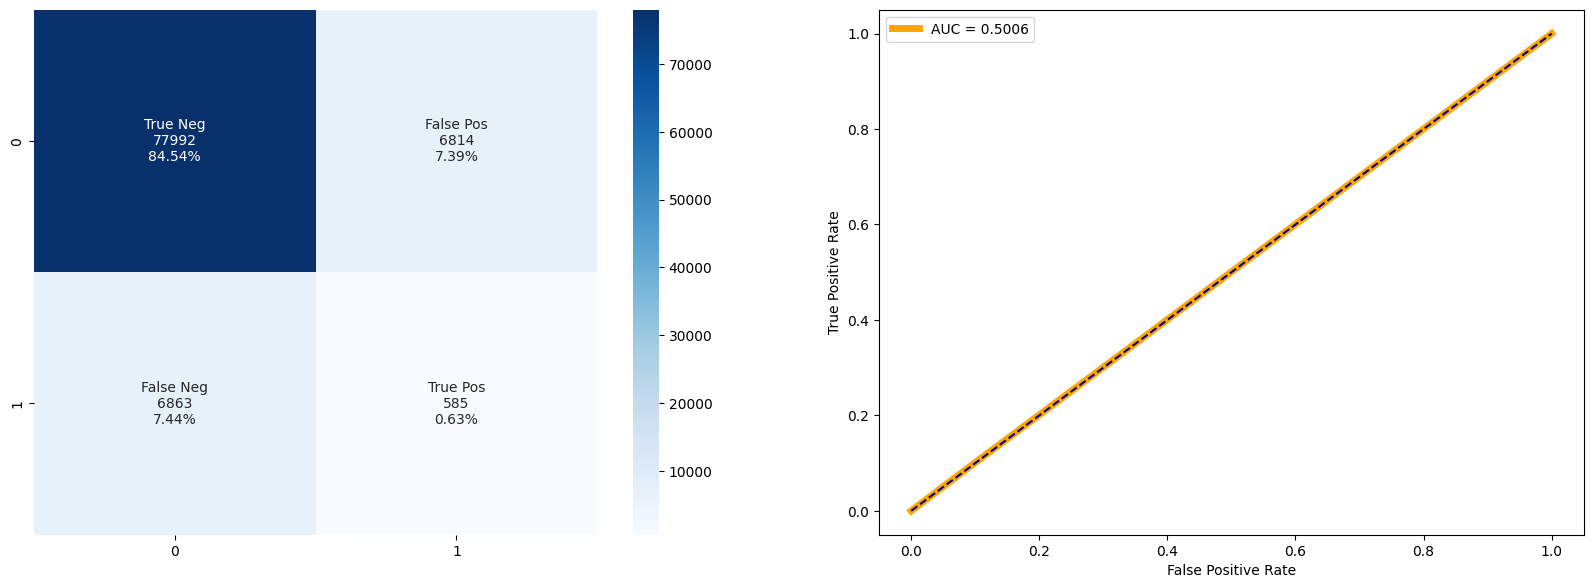

2025/05/06 09:35:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [23]:
train_dummy_model(strategy="stratified", data=final_data)

Un AUC (Area Under the Curve) de 0.50 indique que le modèle n’a aucune capacité à distinguer entre les classes positives et négatives.
C’est équivalent à un tirage au sort, comme lancer une pièce.

In [24]:
pip install pyngrok

In [25]:
mlflow.end_run()

# Conclusion

Notons un fort déséquilibre entre la précision trouvée pour la Target 0 ( environ 0.92) et la Target 1 (0.08). Pour rappel, l'échantillon de travail n'est pas équilibré, avec 92% des individus classés en modalité 0 et 8% en modalité 1, à savoir en défaut de paiement de crédit.

Il est donc intéressant de travailler cet Oversampling (ou suréchantillonnage en français) en ajustant la distribution de classe de manière à avoir une répartition plus égalitaire.

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((215257, 312), (92254, 312), (215257, 1), (92254, 1))

In [ ]:
print("Label 1, Before using undersample: {} ".format(sum(y_train==1)))
print("Label 0, Before using undersample: {} ".format(sum(y_train==0)))

Label 1, Before using undersample: [17377] 
Label 0, Before using undersample: [197880] 


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
n_samples = 70000

# Étape 1 : Sous-échantillonner la classe majoritaire
rus = RandomUnderSampler(sampling_strategy={0: n_samples}, random_state=42)  # Classe 0 (majoritaire) à 50 000 exemples
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Étape 2 : Suréchantillonner la classe minoritaire
smote = SMOTE(sampling_strategy={1: n_samples}, random_state=42)  # Classe 1 (minoritaire) à 50 000 exemples
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_resampled, y_train_resampled)

In [ ]:
print("Label 1, After using SMOTE: {}".format(sum(y_train_resampled==1)))
print("Label 0, After using SMOTE: {}".format(sum(y_train_resampled==0)))

Label 1, After using SMOTE: 70000
Label 0, After using SMOTE: 70000


In [ ]:
X_train_smote=X_train_resampled
y_train_smote=y_train_resampled

In [ ]:
mlflow.set_experiment('Log-Regression-SMOTE')

2025/05/04 19:35:40 INFO mlflow.tracking.fluent: Experiment with name 'Log-Regression-SMOTE' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/drive/MyDrive/mlflow_logs/207145682131394090', creation_time=1746387340961, experiment_id='207145682131394090', last_update_time=1746387340961, lifecycle_stage='active', name='Log-Regression-SMOTE', tags={}>

In [ ]:
#MLFLow Model function Linear Regression
def train_lr_model_smote(C,max_iter,data,X_train_smote,y_train_smote):

    with mlflow.start_run():

        lr = LogisticRegression(C=C,max_iter=max_iter)
        lr.fit(X_train_smote,y_train_smote)

        predicted_qualities=lr.predict(X_test)

        (rmse,mae,r2)=eval_metrics(y_test,predicted_qualities)
        print("ElasticNet model (C=%f,max_iter=%f):" % (C,max_iter))
        print(" RMSE: %s" % rmse)
        print(" MAE:%s" % mae)
        print(" R2:%s" % r2)

        roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
        print('AUC : %0.4f' %roc_auc)
        print(classification_report(y_test, lr.predict(X_test)))
        cf_matrix_roc_auc(lr, y_test, lr.predict(X_test), lr.predict_proba(X_test)[:,1], feature_importances=None,roc_auc=roc_auc)

        mlflow.log_param("C",C)
        mlflow.log_param("max_iter",max_iter)
        mlflow.log_metric("rmse",rmse)
        mlflow.log_metric("r2",r2)
        mlflow.log_metric("mae",mae)
        mlflow.log_metric("AUC",roc_auc)

        mlflow.sklearn.log_model(lr,"model")

ElasticNet model (C=0.001000,max_iter=100.000000):
 RMSE: 0.5601272119353023
 MAE:0.31374249355041517
 R2:-3.227440537628903
AUC : 0.7379
              precision    recall  f1-score   support

         0.0       0.96      0.69      0.80     84806
         1.0       0.16      0.66      0.25      7448

    accuracy                           0.69     92254
   macro avg       0.56      0.67      0.53     92254
weighted avg       0.89      0.69      0.76     92254



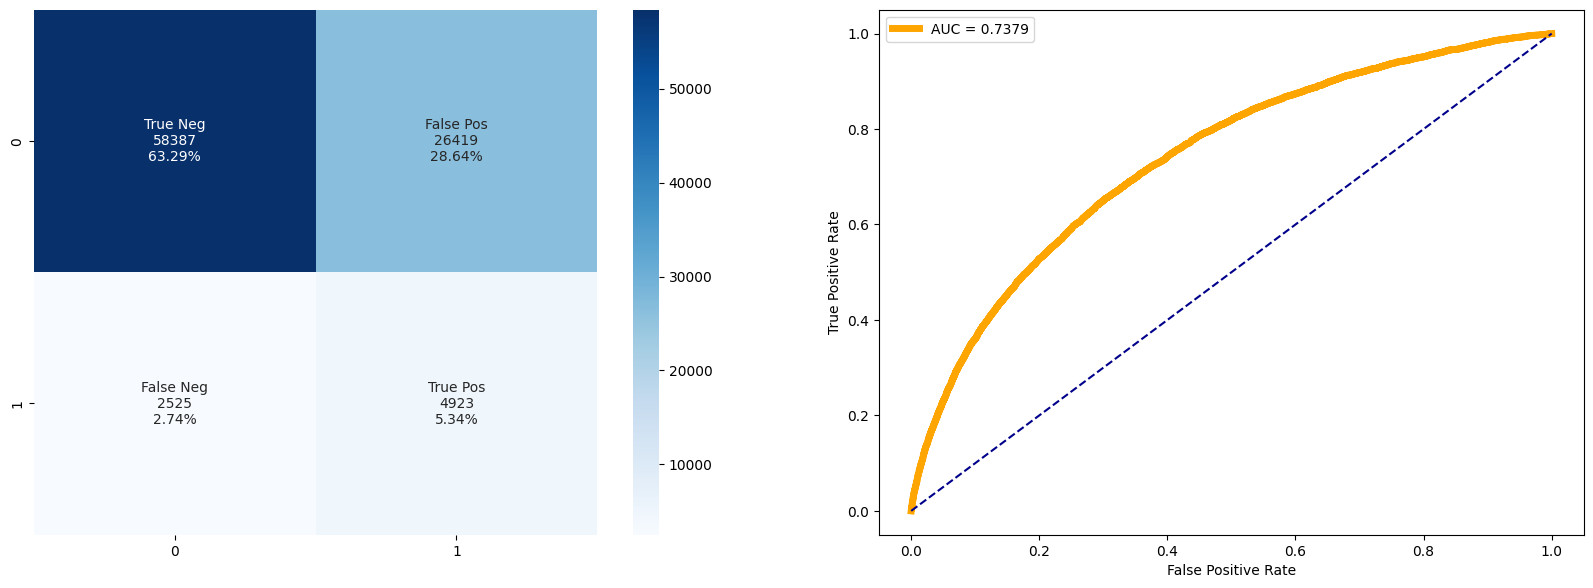

2025/05/04 19:35:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [ ]:
train_lr_model_smote(0.001,100,final_data,X_train_smote,y_train_smote)

In [ ]:
mlflow.end_run()

Amélioration de l'AUC score 0.7379 contre 0.7373 que nous prendrons comme baseline de travail pour la suite des essais.

# COMPARAISON DES DIFFERENTS MODELES

On utilisera les modèles : Catboost, Lightgbm et XGBoost en Classifier.

In [26]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 25.7 MB/s eta 0:00:00


In [27]:
#Predictive Models
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# CatBoostClassifier

In [ ]:
mlflow.set_experiment('Gradient-Boosting-models')

2025/05/04 19:36:22 INFO mlflow.tracking.fluent: Experiment with name 'Gradient-Boosting-models' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/drive/MyDrive/mlflow_logs/153039555943900708', creation_time=1746387382156, experiment_id='153039555943900708', last_update_time=1746387382156, lifecycle_stage='active', name='Gradient-Boosting-models', tags={}>

In [ ]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

def train_model_smote(model, data, X_train_smote, y_train_smote, X_test, y_test):
    from sklearn import metrics
    with mlflow.start_run():
        # Entraînement du modèle
        trained_model = model.fit(X_train_smote, y_train_smote)

        # Prédictions sur les données d'entraînement
        train_predictions = trained_model.predict(X_train_smote)
        train_proba = trained_model.predict_proba(X_train_smote)[:, 1]

        # Prédictions sur les données de test
        test_predictions = trained_model.predict(X_test)
        test_proba = trained_model.predict_proba(X_test)[:, 1]

        # Évaluation sur les données d'entraînement
        print("Évaluation sur les données d'entraînement :")
        print(classification_report(y_train_smote, train_predictions))

        # Matrice de confusion et ROC pour les données d'entraînement
        print("\nMatrice de confusion et ROC pour les données d'entraînement :")
        cf_matrix_roc_auc(
            model,
            y_train_smote,
            train_predictions,
            train_proba,
            feature_importances=None,
            roc_auc=roc_auc_score(y_train_smote, train_proba)
        )

        # Évaluation sur les données de test
        print("\nÉvaluation sur les données de test :")
        print(classification_report(y_test, test_predictions))

        # Matrice de confusion et ROC pour les données de test
        print("\nMatrice de confusion et ROC pour les données de test :")
        cf_matrix_roc_auc(
            model,
            y_test,
            test_predictions,
            test_proba,
            feature_importances=None,
            roc_auc=roc_auc_score(y_test, test_proba)
        )

        # Sauvegarde du modèle et logging dans MLflow
        mlflow.sklearn.log_model(trained_model, "model")


In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, roc_auc_score, classification_report
)

def train_model_smote(model, data, X_train_smote, y_train_smote, X_test, y_test):
    with mlflow.start_run():
        # Entraînement
        trained_model = model.fit(X_train_smote, y_train_smote)

        # Prédictions
        train_pred = trained_model.predict(X_train_smote)
        train_proba = trained_model.predict_proba(X_train_smote)[:, 1]

        test_pred = trained_model.predict(X_test)
        test_proba = trained_model.predict_proba(X_test)[:, 1]

        #  Métriques TRAIN
        mlflow.log_metric("train_accuracy", accuracy_score(y_train_smote, train_pred))
        mlflow.log_metric("train_precision", precision_score(y_train_smote, train_pred))
        mlflow.log_metric("train_recall", recall_score(y_train_smote, train_pred))
        mlflow.log_metric("train_roc_auc", roc_auc_score(y_train_smote, train_proba))

        #  Métriques TEST
        mlflow.log_metric("test_accuracy", accuracy_score(y_test, test_pred))
        mlflow.log_metric("test_precision", precision_score(y_test, test_pred))
        mlflow.log_metric("test_recall", recall_score(y_test, test_pred))
        mlflow.log_metric("test_roc_auc", roc_auc_score(y_test, test_proba))

        #  Affichage console
        print("Évaluation sur les données d'entraînement :")
        print(classification_report(y_train_smote, train_pred))

        print("\nÉvaluation sur les données de test :")
        print(classification_report(y_test, test_pred))

        # 🔍 Courbes & matrice (si cf_matrix_roc_auc est défini)
        print("\nMatrice de confusion et ROC pour les données d'entraînement :")
        cf_matrix_roc_auc(
            model,
            y_train_smote,
            train_pred,
            train_proba,
            feature_importances=None,
            roc_auc=roc_auc_score(y_train_smote, train_proba)
        )

        print("\nMatrice de confusion et ROC pour les données de test :")
        cf_matrix_roc_auc(
            model,
            y_test,
            test_pred,
            test_proba,
            feature_importances=None,
            roc_auc=roc_auc_score(y_test, test_proba)
        )

        # 💾 Sauvegarde du modèle
        mlflow.sklearn.log_model(trained_model, "model")


Évaluation sur les données d'entraînement :
              precision    recall  f1-score   support

         0.0       0.84      0.97      0.90     70000
         1.0       0.96      0.81      0.88     70000

    accuracy                           0.89    140000
   macro avg       0.90      0.89      0.89    140000
weighted avg       0.90      0.89      0.89    140000


Évaluation sur les données de test :
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95     84806
         1.0       0.35      0.22      0.27      7448

    accuracy                           0.90     92254
   macro avg       0.64      0.59      0.61     92254
weighted avg       0.89      0.90      0.89     92254


Matrice de confusion et ROC pour les données d'entraînement :


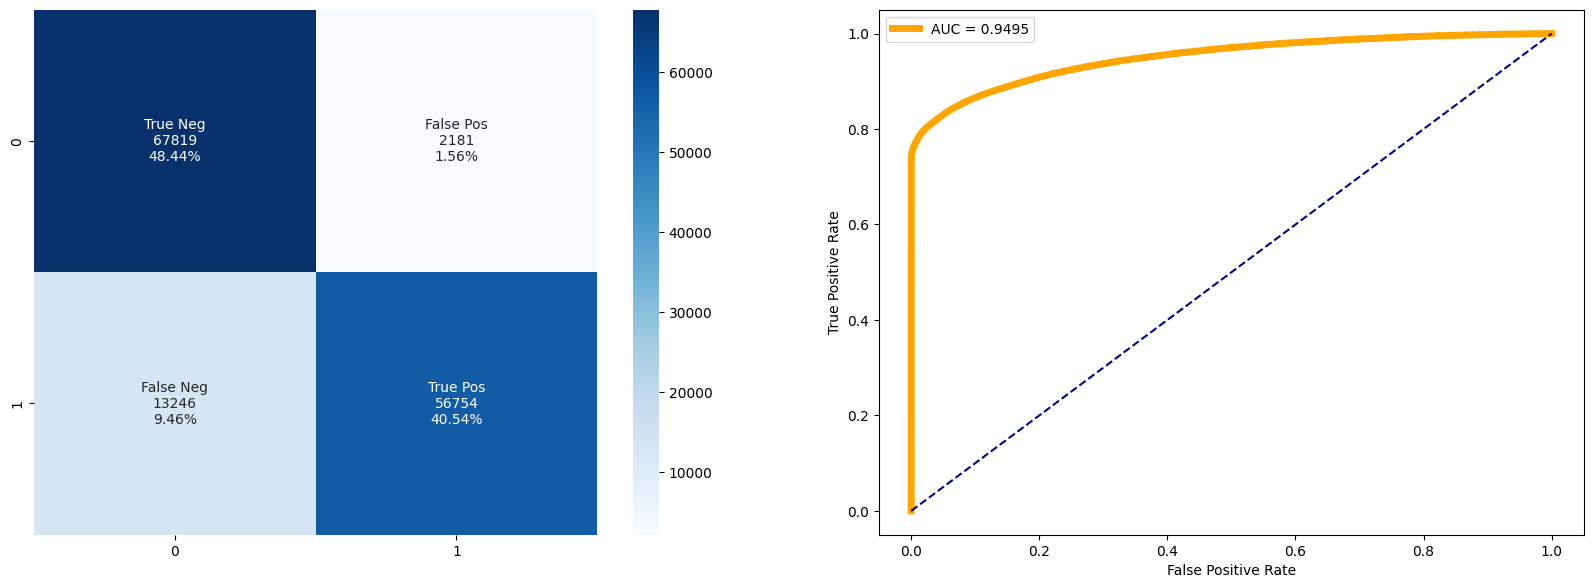


Matrice de confusion et ROC pour les données de test :


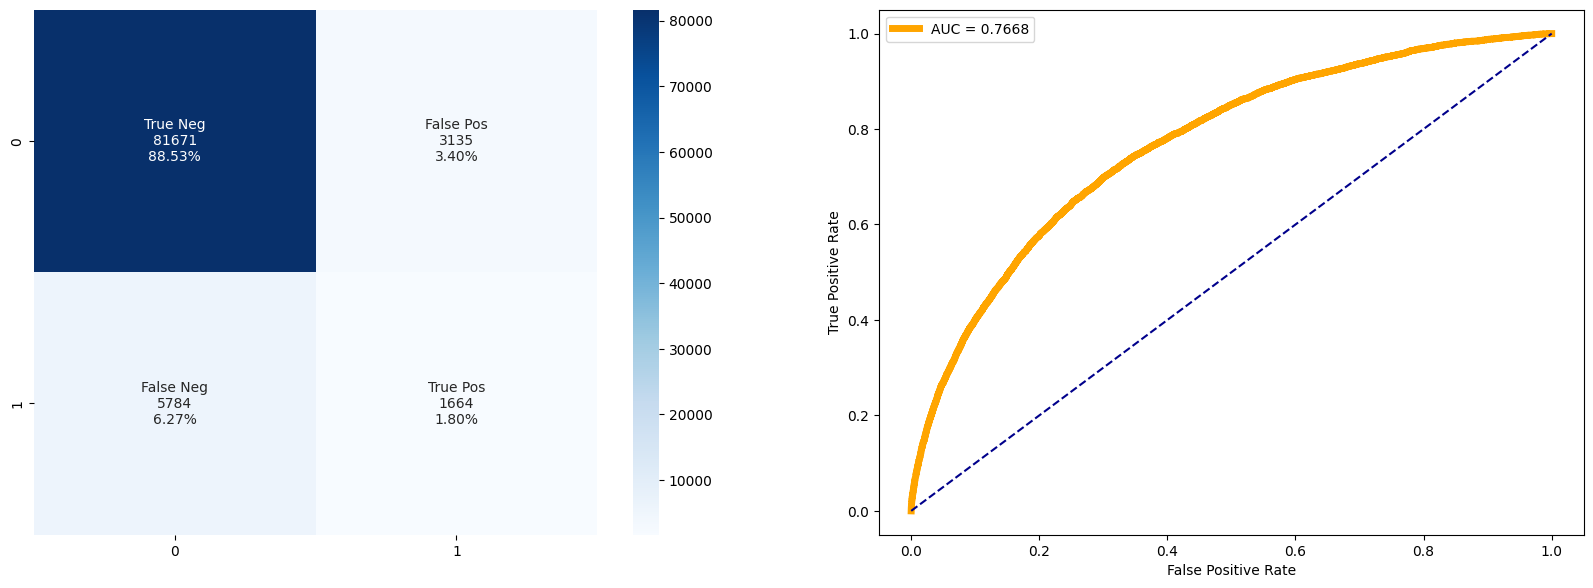

2025/05/04 19:42:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [ ]:
train_model_smote(CatBoostClassifier(task_type="GPU", logging_level='Silent'),final_data,X_train_smote,y_train_smote,X_test,y_test)

# LGBMClassifier

In [ ]:
mlflow.set_experiment('LGBMClassifier-models')

2025/05/04 19:43:05 INFO mlflow.tracking.fluent: Experiment with name 'LGBMClassifier-models' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/drive/MyDrive/mlflow_logs/560475265989169419', creation_time=1746387785179, experiment_id='560475265989169419', last_update_time=1746387785179, lifecycle_stage='active', name='LGBMClassifier-models', tags={}>

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 70000, number of negative: 70000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.188261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65896
[LightGBM] [Info] Number of data points in the train set: 140000, number of used features: 304
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Évaluation sur les données d'entraînement :
              precision    recall  f1-score   support

         0.0       0.84      0.97      0.90     70000
         1.0       0.96      0.81      0.88     70000

    accuracy                           0.89    140000
   macro avg       0.90      0.89      0.89    140000
weighted avg       0.90      0.89      0.89    140000


Évaluation sur les données de test :
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95     84806
         1.0       0.33      0.21      0.26      7448

    accuracy                           0.90     92254
   macro avg       0.63      0.59      0.60     92254
weighted avg       0.88      0.90      0.89     92254


Matrice de confusion et ROC pour les données d'entraînement :


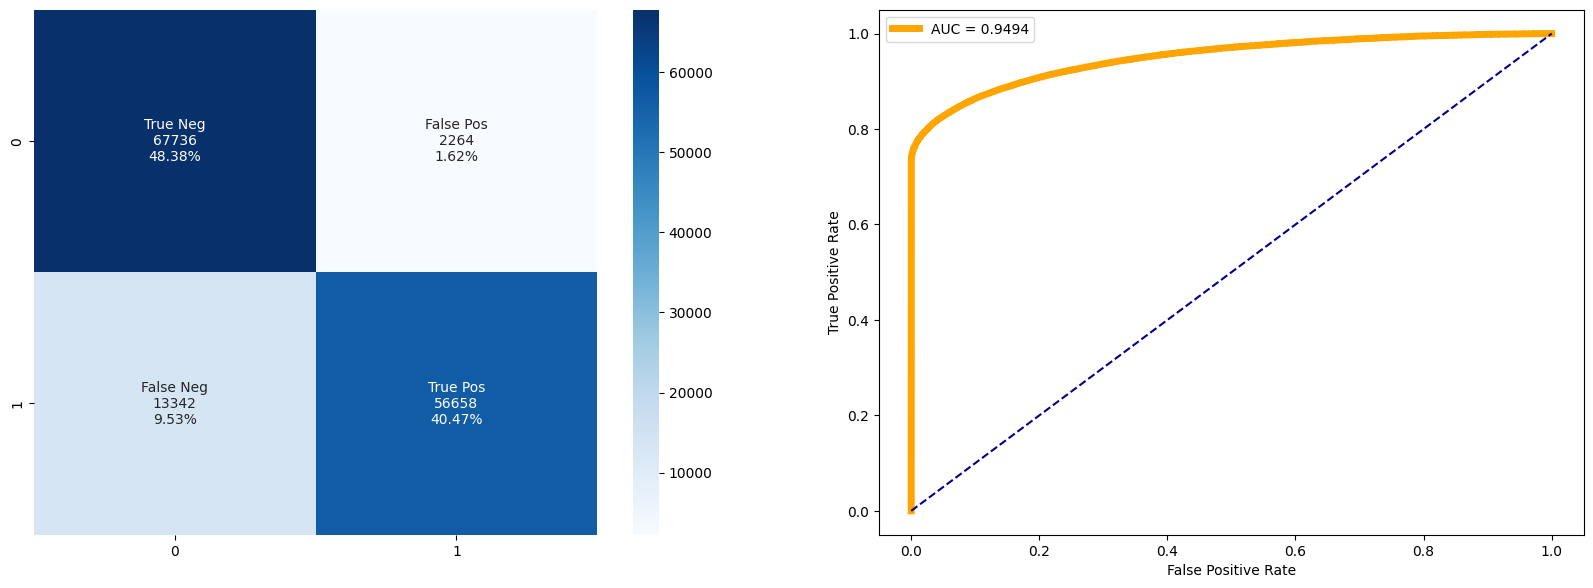


Matrice de confusion et ROC pour les données de test :


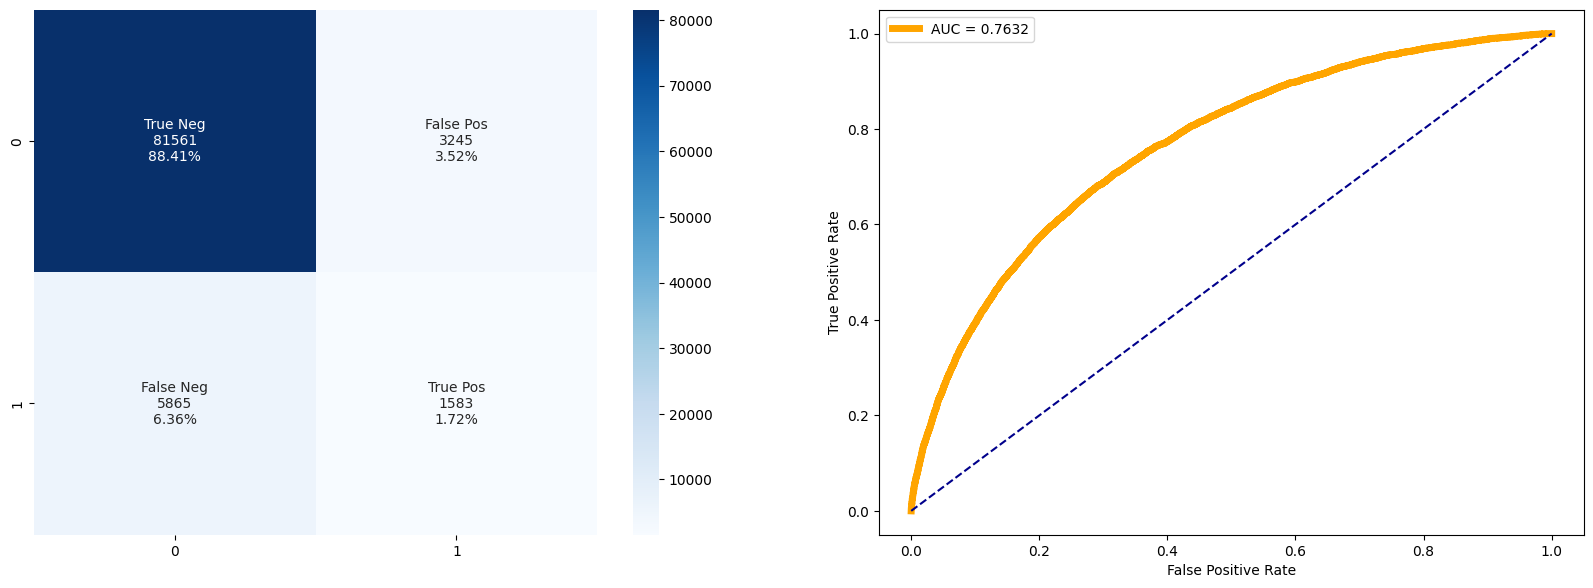

2025/05/04 19:43:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [ ]:
light_boost=LGBMClassifier()
train_model_smote(light_boost,final_data,X_train_smote,y_train_smote,X_test,y_test)

# XGBClassifier

In [ ]:
mlflow.set_experiment('XGBClassifier-models')

2025/05/04 19:43:18 INFO mlflow.tracking.fluent: Experiment with name 'XGBClassifier-models' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/drive/MyDrive/mlflow_logs/155993831142611293', creation_time=1746387798739, experiment_id='155993831142611293', last_update_time=1746387798739, lifecycle_stage='active', name='XGBClassifier-models', tags={}>

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:43:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:43:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:43:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:43:22] WARNING: /workspace/src/common/error_ms

Évaluation sur les données d'entraînement :
              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92     70000
         1.0       0.97      0.85      0.91     70000

    accuracy                           0.91    140000
   macro avg       0.92      0.91      0.91    140000
weighted avg       0.92      0.91      0.91    140000


Évaluation sur les données de test :
              precision    recall  f1-score   support

         0.0       0.94      0.95      0.94     84806
         1.0       0.30      0.26      0.28      7448

    accuracy                           0.89     92254
   macro avg       0.62      0.60      0.61     92254
weighted avg       0.88      0.89      0.89     92254


Matrice de confusion et ROC pour les données d'entraînement :


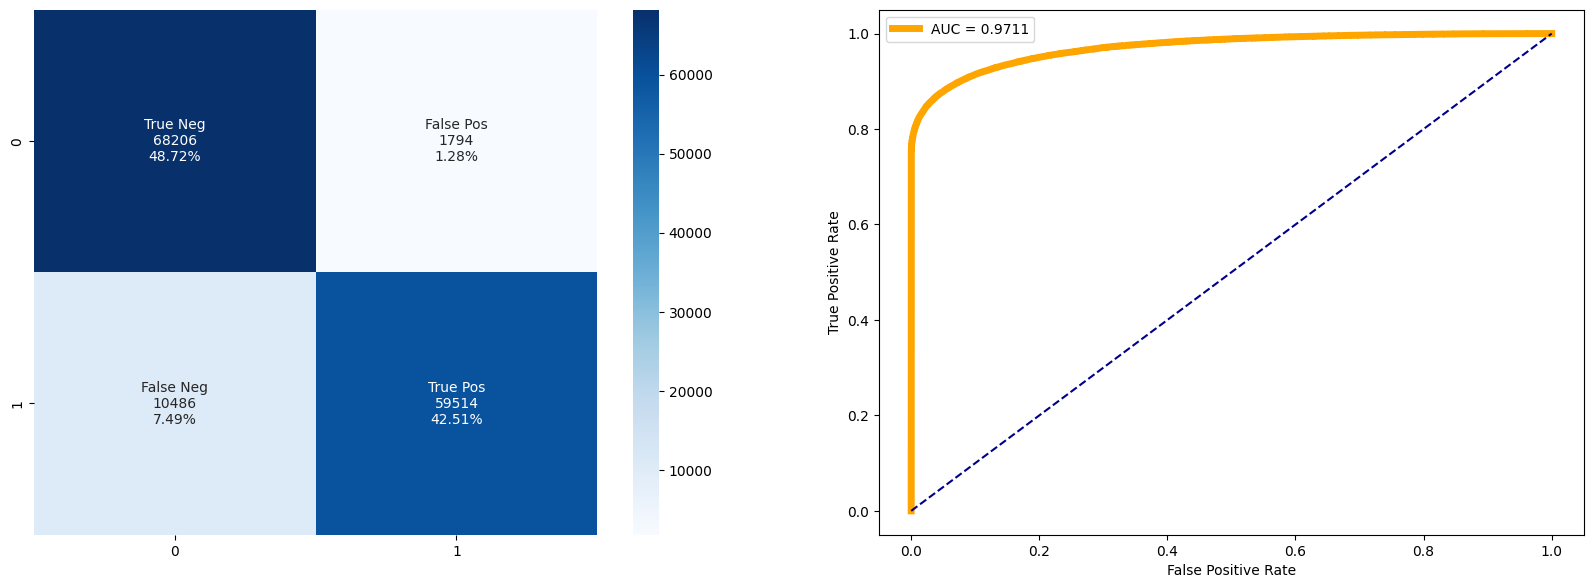


Matrice de confusion et ROC pour les données de test :


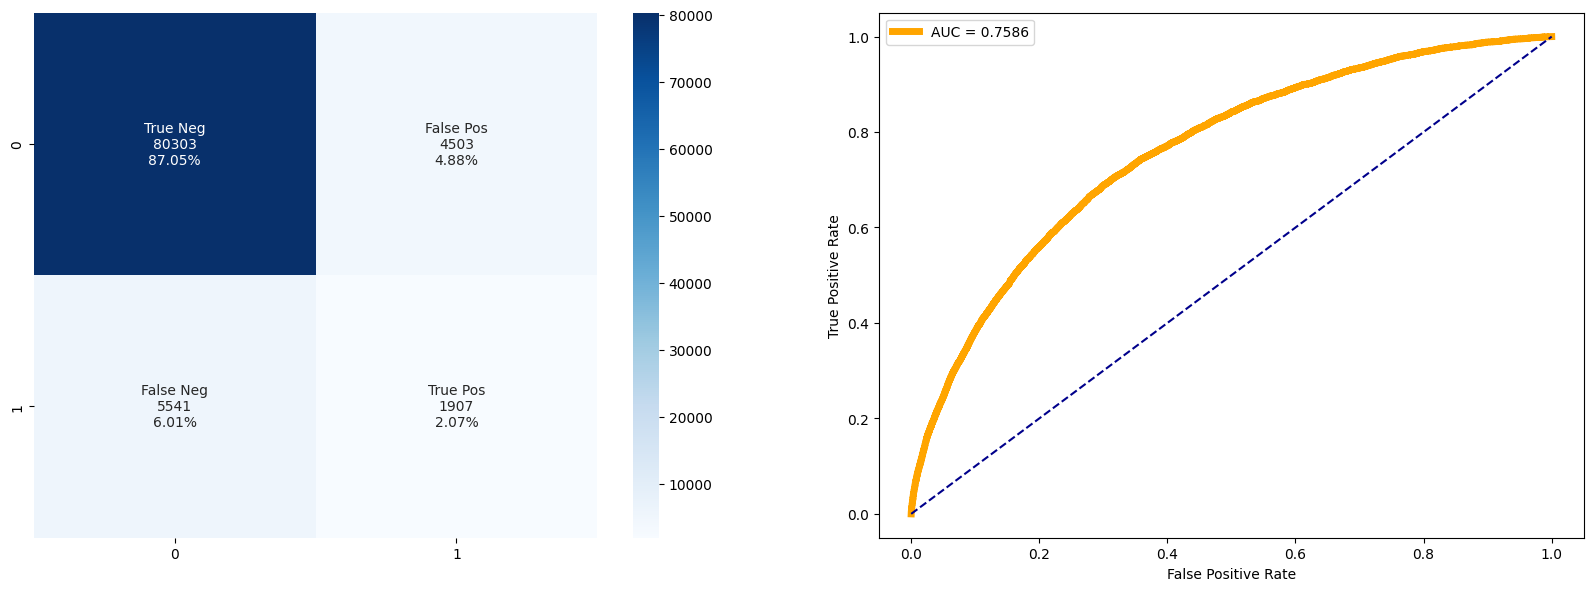

2025/05/04 19:43:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [ ]:
train_model_smote(XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor'),final_data,X_train_smote,y_train_smote,X_test,y_test)

In [ ]:
models = [
          CatBoostClassifier(task_type="GPU", logging_level='Silent'),
          LGBMClassifier(),
          XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')]

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn import metrics

def train_models(model, X_train, X_test, y_train, y_test, seuil=0.3):
    model.fit(X_train, y_train)

    # Prédire les probabilités
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_test_proba = model.predict_proba(X_test)[:, 1]

    # Appliquer le seuil pour obtenir les labels de classe prédits
    y_train_pred = (y_train_proba >= seuil).astype(int)
    y_test_pred = (y_test_proba >= seuil).astype(int)

    output = {
      'AUC_train': roc_auc_score(y_train, y_train_proba),
      'Accuracy_train': accuracy_score(y_train, y_train_pred),
      'Precision_train': precision_score(y_train, y_train_pred),
      'Recall_train': recall_score(y_train, y_train_pred),
      'F1_train': f1_score(y_train, y_train_pred, average='weighted'),

      'AUC': roc_auc_score(y_test, y_test_proba),
      'Accuracy': accuracy_score(y_test, y_test_pred),
      'Precision': precision_score(y_test, y_test_pred),
      'Recall': recall_score(y_test, y_test_pred),
      'F1': f1_score(y_test, y_test_pred, average='weighted')
    }

    return output


In [ ]:
import time
import pandas as pd

# Initialisation des listes pour stocker les résultats
name = []
auc_train = []
auc_test = []
accuracy_train = []
accuracy_test = []
precision_train = []
precision_test = []
recall_train = []
recall_test = []
f1_train = []
f1_test = []
time_ = []

# Boucle sur chaque modèle pour entraîner et évaluer
for model in models:
    start = time.time()
    results = train_models(model, X_train_smote, X_test, y_train_smote, y_test)

    # Ajouter le nom du modèle
    name.append(type(model).__name__)

    # Récupérer les résultats pour l'ensemble d'entraînement et de test
    # Access dictionary elements directly using keys
    auc_train.append(results['AUC_train'])
    auc_test.append(results['AUC'])

    accuracy_train.append(results['Accuracy_train'])
    accuracy_test.append(results['Accuracy'])

    precision_train.append(results['Precision_train'])
    precision_test.append(results['Precision'])

    recall_train.append(results['Recall_train'])
    recall_test.append(results['Recall'])

    f1_train.append(results['F1_train'])
    f1_test.append(results['F1'])

    # Calculer le temps d'exécution pour chaque modèle
    time_.append(time.time()-start)

# Initialisation du DataFrame avec les résultats collectés
models_res = pd.DataFrame(data=[name, auc_train, auc_test, accuracy_train, accuracy_test,
                                precision_train, precision_test, recall_train, recall_test,
                                f1_train, f1_test, time_]).T

models_res.columns = ['Model', 'AUC_train', 'AUC_test', 'Accuracy_train', 'Accuracy_test',
                      'Precision_train', 'Precision_test', 'Recall_train', 'Recall_test',
                      'F1_train', 'F1_test', 'Time']

# Trier les modèles en fonction de l'AUC sur les données de test (en ordre décroissant)
models_res.sort_values('AUC_test', ascending=False, inplace=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 70000, number of negative: 70000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.169169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65896
[LightGBM] [Info] Number of data points in the train set: 140000, number of used features: 304
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:44:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:44:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarni

In [ ]:
models_res

,Model,AUC_train,AUC_test,Accuracy_train,Accuracy_test,Precision_train,Precision_test,Recall_train,Recall_test,F1_train,F1_test,Time
0,CatBoostClassifier,0.949591,0.76702,0.864264,0.801169,0.842202,0.213002,0.8965,0.54283,0.864123,0.837298,46.248404
1,LGBMClassifier,0.949356,0.76317,0.864929,0.800063,0.844477,0.210102,0.894614,0.535043,0.864809,0.836373,5.517563
2,XGBClassifier,0.971097,0.758559,0.899857,0.800811,0.879783,0.207776,0.926286,0.521617,0.899787,0.836589,2.221173


In [ ]:
mlflow.end_run()

Conclusion: Le Catboost et le XGBCLassifier semblent performants avec les données equilibres cependant le LightGBM reste raisonnable en terme de precision et de temps.

# 6. Features Selection - Recursive Feature Elimination

Maintenant que nous avons testé ces 3 modèles, on peut effectuer cette étape avec LGBMClassifier qui permet d'obtenir les meilleurs performances AUC score / Time. À ce stade, nos ensembles de données contiennent 309 features, dont beaucoup peuvent ne pas contenir d'informations utiles. RFECV avec Scikit-learn appliquera une validation croisée pour trouver l'ensemble des features optimal qui maximisera nos performances. Le but est donc d'optimiser la métrique AUC tout en éliminant les features les moins importantes.

In [ ]:
%%time
start = time.time()
rfecv = RFECV(estimator=LGBMClassifier(objective='binary'),
              step=15,
              cv=StratifiedKFold(3),
              scoring='roc_auc',
              verbose=2,
              n_jobs=-1)
rfecv.fit(X_train_smote, y_train_smote)
print('Time Elapsed: {}'.format(time.time()-start))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

Fitting estimator with 312 features.


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 70000, number of negative: 70000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 65803
[LightGBM] [Info] Number of data points in the train set: 140000, number of used features: 302
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Fitting estimator with 297 features.


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 70000, number of negative: 70000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051997 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 63648
[LightGBM] [Info] Number of data points in the train set: 140000, number of used features: 289
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Fitting estimator with 282 features.


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 70000, number of negative: 70000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60404
[LightGBM] [Info] Number of data points in the train set: 140000, number of used features: 274
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Fitting estimator with 267 features.


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 70000, number of negative: 70000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.115730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58296
[LightGBM] [Info] Number of data points in the train set: 140000, number of used features: 260
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Fitting estimator with 252 features.


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 70000, number of negative: 70000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 56899
[LightGBM] [Info] Number of data points in the train set: 140000, number of used features: 249
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Fitting estimator with 237 features.


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 70000, number of negative: 70000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 54955
[LightGBM] [Info] Number of data points in the train set: 140000, number of used features: 235
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Fitting estimator with 222 features.


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 70000, number of negative: 70000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51784
[LightGBM] [Info] Number of data points in the train set: 140000, number of used features: 220
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Fitting estimator with 207 features.


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 70000, number of negative: 70000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 48697
[LightGBM] [Info] Number of data points in the train set: 140000, number of used features: 205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Fitting estimator with 192 features.


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 70000, number of negative: 70000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 47228
[LightGBM] [Info] Number of data points in the train set: 140000, number of used features: 192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 70000, number of negative: 70000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44720
[LightGBM] [Info] Number of data points in the train set: 140000, number of used features: 177
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 70000, number of negative: 70000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44720
[LightGBM] [Info] Number of data points in the train set: 140000, number of used features: 177
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Time Elapsed: 272.1532118320465
CPU times: user 4min 13s, sys: 2.34 s, total: 4min 15s
Wall time: 4min 32s


In [ ]:
print("Optimal number of features : %d" % rfecv.n_features_)
print("Selected Features: %s" % rfecv.support_[:20])
print("Feature Ranking : %s" % rfecv.ranking_[:20])

Optimal number of features : 177
Selected Features: [ True  True  True  True  True  True  True  True  True  True  True False
 False  True False  True  True  True  True  True]
Feature Ranking : [1 1 1 1 1 1 1 1 1 1 1 8 8 1 6 1 1 1 1 1]


In [ ]:
def cf_matrix_roc_auc(model,X_data,y_true, y_pred, y_pred_proba, feature_importances,roc_auc):
    '''This function will make a pretty plot of
  an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    fig = plt.figure(figsize=(20,15))

    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    if feature_importances :
        plt.subplot(212)
        indices = np.argsort(model.feature_importances_)[::-1]

    features = []
    for i in range(20):
        features.append(X_data.columns[np.argsort(model.feature_importances_)[::-1][i]]) #After RFECV selection > X_data created

    sns.barplot(x=features, y=model.feature_importances_[np.argsort(model.feature_importances_)[::-1][range(20)]], color=("orange"))
    plt.xlabel('Features importance')
    plt.xticks(rotation=90)

    plt.show()

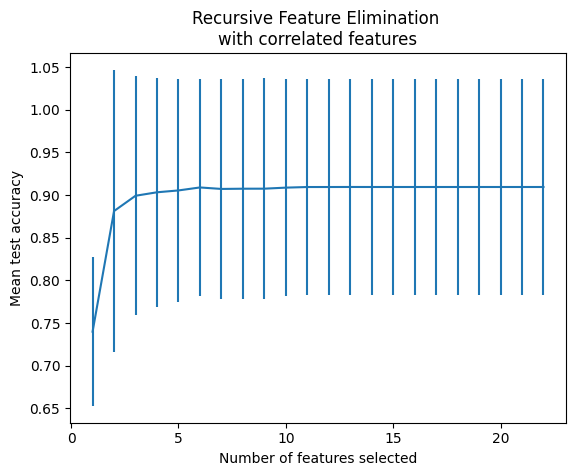

In [ ]:
#Plot number of features vs CV scores
import matplotlib.pyplot as plt

min_features_to_select = 1
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [ ]:
X1=rfecv.transform(X_train_smote)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

In [ ]:
import lightgbm as lgb

In [ ]:
clf = lgb.LGBMClassifier(objective="binary",
                         n_jobs=-1, is_unbalance=True)

# entraînement du modèle
clf.fit(X1, y_train_smote)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 70000, number of negative: 70000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44720
[LightGBM] [Info] Number of data points in the train set: 140000, number of used features: 177
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


LGBMClassifier(is_unbalance=True, n_jobs=-1, objective='binary')

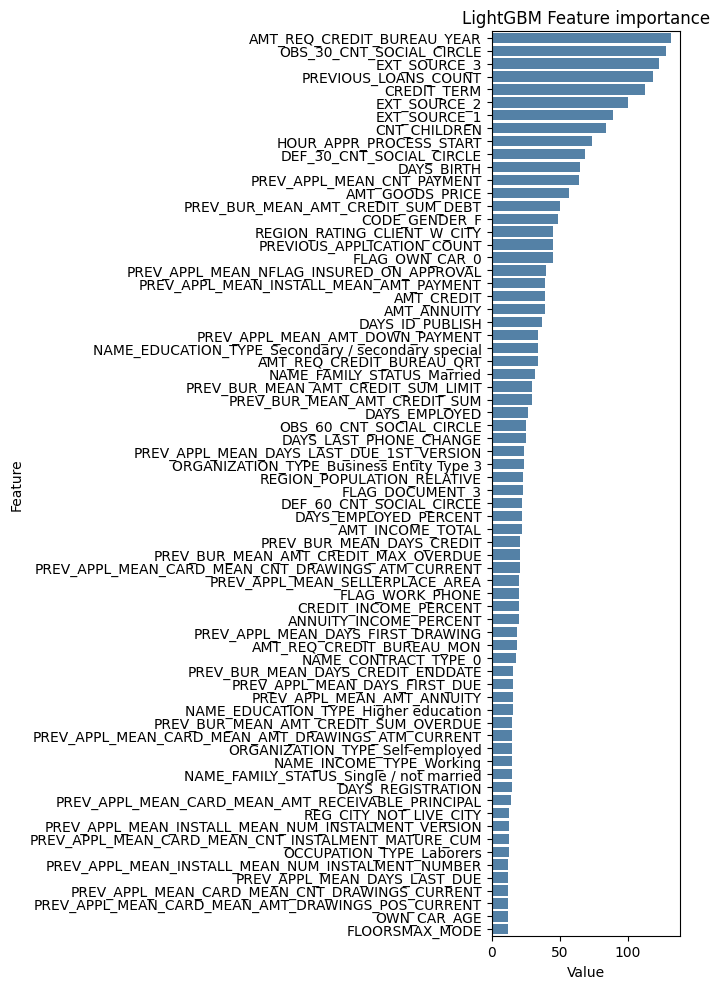

In [ ]:
import pandas as pd

# Assuming X_original was your original DataFrame before transformations
feature_names = data_train.columns[rfecv.support_]

feature_imp = pd.DataFrame(sorted(zip(
    clf.feature_importances_, feature_names), reverse=True), columns=['Value', 'Feature'])

# importance de chaque feature sur le total (%)
feature_imp["pct"] = (feature_imp.Value / sum(feature_imp.Value)) * 100

# importance de chaque feature sur le total (somme cumulée %)
feature_imp["pct_cum"] = np.cumsum(feature_imp["pct"])

# Représentation graphique
plt.figure(figsize=(7, 10))
sns.barplot(x="Value", y="Feature",
            data=feature_imp.iloc[:70], color='steelblue')
plt.title('LightGBM Feature importance')
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Importance value')

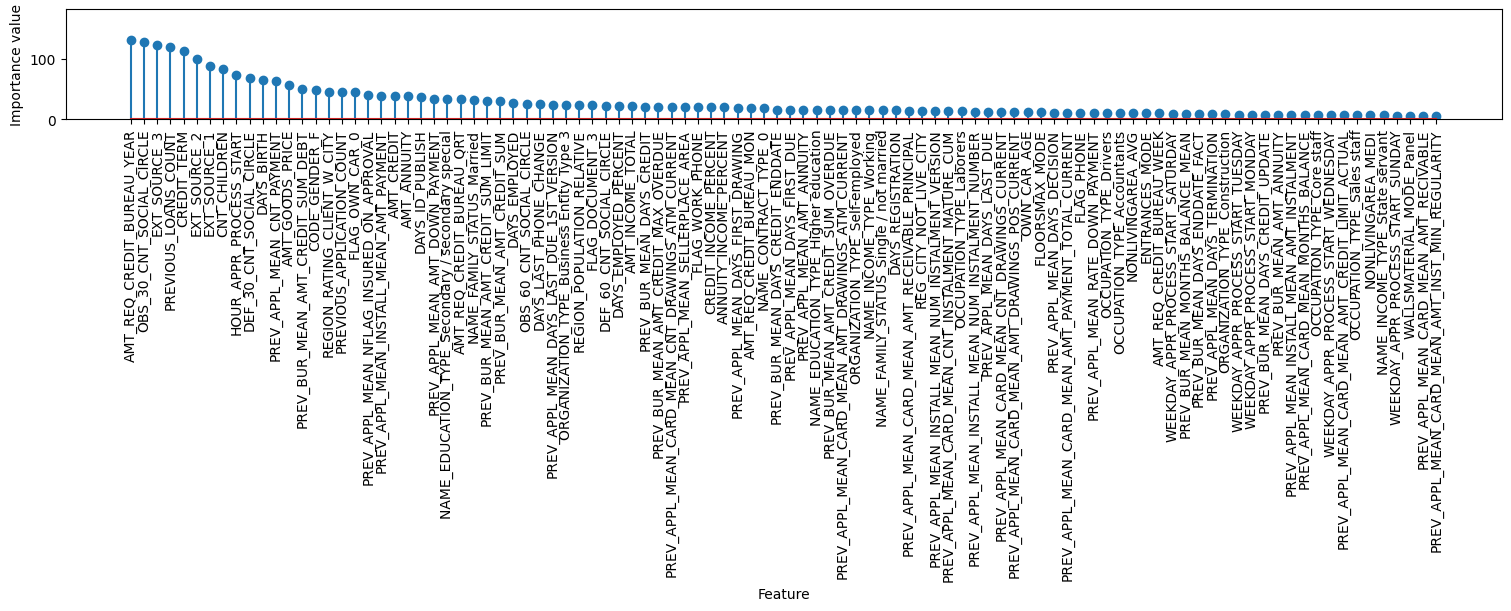

In [ ]:
plt.figure(figsize=(15, 6), dpi=100, constrained_layout=True)
plt.stem(feature_imp['Value'].iloc[:100])
plt.xticks(range(0, len(feature_imp.iloc[:100].index)),
           feature_imp['Feature'].iloc[:100], rotation=90)
plt.ylim(0, feature_imp['Value'].iloc[:100].max()+50)
plt.xlabel("Feature")
plt.ylabel('Importance value')

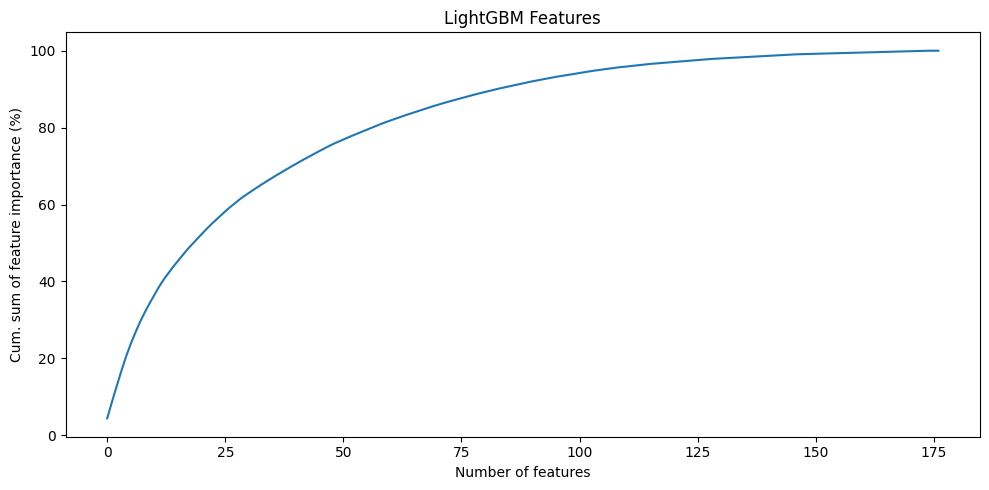

In [ ]:
# Représentation graphique de la somme cumulée (%) de chaque feature

plt.figure(figsize=(10, 5))
sns.lineplot(x=feature_imp.index, y="pct_cum", data=feature_imp)
plt.title('LightGBM Features')
plt.xlabel("Number of features")
plt.ylabel("Cum. sum of feature importance (%)")
plt.tight_layout()
plt.show()

In [ ]:
# Récupération de la liste des 60 features les plus importantes
list_feature_lgb = list(feature_imp.iloc[:60].Feature)

list_feature_lgb.append('TARGET')
list_feature_lgb = pd.Series(list_feature_lgb, name="Col_to_keep")

In [ ]:
df_selected = final_data[list_feature_lgb]

In [ ]:
df_selected.shape

(307511, 61)

In [ ]:
# Sauvegarder en CSV
df_selected.to_csv("/content/drive/MyDrive/Colab Notebooks/df_selected.csv")  # index=False évite d'inclure l'index dans le fichier
print("Fichier CSV sauvegardé : features.csv")

Fichier CSV sauvegardé : features.csv


# 7. La fonction coût

La problématique est de prendre en compte qu’un faux positifs (bon client considéré comme mauvais = crédit non accordé à tort, donc manque à gagner de la marge pour la banque) n’a pas le même coût qu’un faux négatif (mauvais client à qui on accorde un prêt, donc perte sur le capital non remboursé). Un faux négatif est environ 10 fois plus coûteux qu’un faux positif. Les mesures techniques tels que le f1 score ne le prennent pas en compte.

Le score “métier” consiste à calculer une fonction de coût métier de type 10*FN + FP (où FN = nombre de FN dans la matrice de confusion pour un seuil donné, FP = nombre de FP) et de trouver son minimum pour un seuil donné.

On peut se fixer l'hypothèse d'un Beta = 10. Vérifions-le avec une étape de tests fonctionnels.

In [28]:
df_selected=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/df_selected.csv")

In [29]:
df_selected = df_selected.drop(columns=['Unnamed: 0'])
df_selected

,AMT_REQ_CREDIT_BUREAU_YEAR,OBS_30_CNT_SOCIAL_CIRCLE,EXT_SOURCE_3,PREVIOUS_LOANS_COUNT,CREDIT_TERM,EXT_SOURCE_2,EXT_SOURCE_1,CNT_CHILDREN,HOUR_APPR_PROCESS_START,DEF_30_CNT_SOCIAL_CIRCLE,...,PREV_APPL_MEAN_AMT_ANNUITY,NAME_EDUCATION_TYPE_Higher education,PREV_BUR_MEAN_AMT_CREDIT_SUM_OVERDUE,PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_ATM_CURRENT,ORGANIZATION_TYPE_Self-employed,NAME_INCOME_TYPE_Working,NAME_FAMILY_STATUS_Single / not married,DAYS_REGISTRATION,PREV_APPL_MEAN_CARD_MEAN_AMT_RECEIVABLE_PRINCIPAL,TARGET
0,0.04,0.005747,0.155054,0.060870,0.377861,0.307542,0.072215,0.0,0.434783,0.058824,...,0.030796,0.0,0.0,0.006752,0.0,1.0,1.0,0.852140,0.034389,1.0
1,0.00,0.002874,0.597163,0.026087,0.053985,0.727773,0.312933,0.0,0.478261,0.000000,...,0.188246,1.0,0.0,0.006752,0.0,0.0,0.0,0.951929,0.034389,0.0
2,0.00,0.000000,0.814130,0.008696,0.272843,0.650190,0.518318,0.0,0.391304,0.000000,...,0.017832,0.0,0.0,0.006752,0.0,1.0,1.0,0.827335,0.034389,0.0
3,0.04,0.005747,0.597163,0.026087,0.711908,0.760751,0.518318,0.0,0.739130,0.000000,...,0.078726,0.0,0.0,0.006752,0.0,1.0,0.0,0.601451,0.003302,0.0
4,0.00,0.000000,0.597163,0.000000,0.200770,0.377472,0.518318,0.0,0.478261,0.000000,...,0.040871,0.0,0.0,0.006752,0.0,1.0,1.0,0.825268,0.034389,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0.04,0.000000,0.597163,0.026087,0.841421,0.797231,0.138170,0.0,0.652174,0.000000,...,0.021989,0.0,0.0,0.006752,0.0,1.0,0.0,0.657263,0.034389,0.0
307507,0.04,0.000000,0.597163,0.026087,0.219346,0.135663,0.518318,0.0,0.347826,0.000000,...,0.033534,0.0,0.0,0.006752,0.0,0.0,0.0,0.822147,0.034389,0.0
307508,0.04,0.017241,0.243815,0.026087,0.216557,0.626575,0.769370,0.0,0.391304,0.000000,...,0.015879,1.0,0.0,0.006752,0.0,1.0,0.0,0.726937,0.034389,0.0
307509,0.00,0.000000,0.737587,0.000000,0.317709,0.601360,0.518318,0.0,0.391304,0.000000,...,0.035553,0.0,0.0,0.006752,0.0,0.0,0.0,0.896158,0.034389,1.0


In [30]:
def my_score(predictions_success: list) -> float:
    '''scoring fonction'''
    tp, tn, fp, fn = predictions_success

    # Paramètre beta
    beta = 10
    # Calcul du F-score modifié
    score = round(((beta*fn)+fp)/(tp+tn+fn+fp), 2)

    return score

# Test des cas donnés
test_0 = [500, 300, 10, 30]
test_1 = [500, 300, 30, 10]
test_2 = [400, 300, 70, 50]
test_3 = [400, 300, 50, 70]
test_4 = [350, 250, 80, 120]
test_5 = [350, 250, 180, 90]

tests = [test_0, test_1, test_2, test_3, test_4, test_5]

for i, t in enumerate(tests):
    print("############################")
    print("Test", i, ":", t)
    print("Score :", my_score(t))

############################
Test 0 : [500, 300, 10, 30]
Score : 0.37
############################
Test 1 : [500, 300, 30, 10]
Score : 0.15
############################
Test 2 : [400, 300, 70, 50]
Score : 0.7
############################
Test 3 : [400, 300, 50, 70]
Score : 0.91
############################
Test 4 : [350, 250, 80, 120]
Score : 1.6
############################
Test 5 : [350, 250, 180, 90]
Score : 1.24


Les résultats sont satisfaisants, les risques liés aux erreurs de faux négatifs et positifs font ressortir un score plus importants, à l'inverse un dossier présentant moins de risque aura un score proche de zéro.

In [31]:
def custom_score(y_true, y_pred, beta=10):
    '''Fonction qui pénalise les faux positifs (fp) et faux négatifs (fn) selon un F-score modifié (F-beta).'''
    # Calcul de la matrice de confusion
    tp, tn, fp, fn = confusion_matrix(y_true, y_pred).ravel()


    # Calcul du F-score modifié (F-beta)
    score = round(((beta*fn)+fp)/(tp+tn+fn+fp), 2)

    return score

# Model evaluation

In [32]:
X = df_selected.drop('TARGET', axis=1)
y = df_selected.TARGET

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.3, random_state=42,stratify=y.values)

In [ ]:
print(f"Taille de X_train : {X_train.shape}")
print(f"Taille de X_test : {X_test.shape}")
print(f"Taille de y_train : {y_train.shape}")
print(f"Taille de y_test : {y_test.shape}")

Taille de X_train : (215257, 60)
Taille de X_test : (92254, 60)
Taille de y_train : (215257,)
Taille de y_test : (92254,)


In [34]:
print("Label 1, Before using SMOTE: {} ".format(sum(y_train==1)))
print("Label 0, Before using SMOTE: {} ".format(sum(y_train==0)))

Label 1, Before using SMOTE: 17377 
Label 0, Before using SMOTE: 197880 


In [35]:
n_samples = 70000
from imblearn.under_sampling import RandomUnderSampler
# Étape 1 : Sous-échantillonner la classe majoritaire
rus = RandomUnderSampler(sampling_strategy={0: n_samples}, random_state=42)  # Classe 0 (majoritaire) à 70 000 exemples
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Étape 2 : Suréchantillonner la classe minoritaire
smote = SMOTE(sampling_strategy={1: n_samples}, random_state=42)  # Classe 1 (minoritaire) à 70 000 exemples
X_train_res, y_train_res = smote.fit_resample(X_train_resampled, y_train_resampled)

In [36]:
print("Label 1, After using SMOTE: {}".format(sum(y_train_res==1)))
print("Label 0, After using SMOTE: {}".format(sum(y_train_res==0)))

Label 1, After using SMOTE: 70000
Label 0, After using SMOTE: 70000


In [37]:
X_train_smote=X_train_res
y_train_smote=y_train_res

In [38]:
mlflow.set_experiment('lgbm optimisé')

2025/05/06 09:39:12 INFO mlflow.tracking.fluent: Experiment with name 'lgbm optimisé' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/drive/MyDrive/mlflow_logs/546646185334199588', creation_time=1746524352678, experiment_id='546646185334199588', last_update_time=1746524352678, lifecycle_stage='active', name='lgbm optimisé', tags={}>

In [ ]:
import mlflow
mlflow.set_tracking_uri("file:/content/drive/MyDrive/mlflow_logs")

In [ ]:
from pyngrok import ngrok
#Terminer les tunnels ouverts s'ils existent
ngrok.kill()
#recuperer le authtoken
NGROK_AUTH_TOKEN = '2oOmO8YSY5n0osOzZD2KDTwyxMi_7ZAPDTSZJguNgZHauP7dw'
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

ngrok_tunnel = ngrok.connect(addr='5000', proto='http', bind_tls=True)
print('MLflow Tracking UI:', ngrok_tunnel.public_url)

MLflow Tracking UI: https://4077-35-240-207-255.ngrok-free.app


In [ ]:
! mlflow ui

[2025-05-04 21:08:47 +0000] [10688] [INFO] Starting gunicorn 23.0.0
[2025-05-04 21:08:47 +0000] [10688] [INFO] Listening at: http://127.0.0.1:5000 (10688)
[2025-05-04 21:08:47 +0000] [10688] [INFO] Using worker: sync
[2025-05-04 21:08:47 +0000] [10689] [INFO] Booting worker with pid: 10689
[2025-05-04 21:08:47 +0000] [10690] [INFO] Booting worker with pid: 10690
[2025-05-04 21:08:47 +0000] [10691] [INFO] Booting worker with pid: 10691
[2025-05-04 21:08:47 +0000] [10696] [INFO] Booting worker with pid: 10696


In [ ]:
def train_model_rfe(model, data, X_data, X_train_smote, X_test, y_train_smote, y_test, seuil=0.3):
    with mlflow.start_run():
        # Entraînement
        trained_model = model.fit(X_train_smote, y_train_smote)

        # Prédictions entraînement
        y_train_proba = trained_model.predict_proba(X_train_smote)[:, 1]
        y_train_pred = (y_train_proba >= seuil).astype(int)

        # Prédictions test
        y_test_proba = trained_model.predict_proba(X_test)[:, 1]
        y_test_pred = (y_test_proba >= seuil).astype(int)

        #  Métriques TRAIN
        train_acc = accuracy_score(y_train_smote, y_train_pred)
        train_prec = precision_score(y_train_smote, y_train_pred)
        train_rec = recall_score(y_train_smote, y_train_pred)
        train_auc = roc_auc_score(y_train_smote, y_train_proba)

        #  Métriques TEST
        test_acc = accuracy_score(y_test, y_test_pred)
        test_prec = precision_score(y_test, y_test_pred)
        test_rec = recall_score(y_test, y_test_pred)
        test_auc = roc_auc_score(y_test, y_test_proba)

        #  Affichage console
        print("Évaluation sur les données d'entraînement :")
        print(classification_report(y_train_smote, y_train_pred))

        print("\nMatrice de confusion et ROC pour les données d'entraînement :")
        cf_matrix_roc_auc(
            model=trained_model,
            X_data=X_data,
            y_true=y_train_smote,
            y_pred=y_train_pred,
            y_pred_proba=y_train_proba,
            feature_importances=None,
            roc_auc=train_auc
        )

        print("\nÉvaluation sur les données de test :")
        print(classification_report(y_test, y_test_pred))

        print("\nMatrice de confusion et ROC pour les données de test :")
        cf_matrix_roc_auc(
            model=trained_model,
            X_data=X_data,
            y_true=y_test,
            y_pred=y_test_pred,
            y_pred_proba=y_test_proba,
            feature_importances=None,
            roc_auc=test_auc
        )

        #  Custom Score
        custom_score_value = custom_score(y_test, y_test_pred)
        print(f"Custom Score: {custom_score_value:.4f}")

        #  Log modèle
        mlflow.sklearn.log_model(trained_model, "model")

        #  Log métriques dans MLflow
        mlflow.log_metric("train_accuracy", train_acc)
        mlflow.log_metric("train_precision", train_prec)
        mlflow.log_metric("train_recall", train_rec)
        mlflow.log_metric("train_roc_auc", train_auc)

        mlflow.log_metric("test_accuracy", test_acc)
        mlflow.log_metric("test_precision", test_prec)
        mlflow.log_metric("test_recall", test_rec)
        mlflow.log_metric("test_roc_auc", test_auc)

        mlflow.log_metric("custom_score", custom_score_value)



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 70000, number of negative: 70000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14731
[LightGBM] [Info] Number of data points in the train set: 140000, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Évaluation sur les données d'entraînement :
              precision    recall  f1-score   support

         0.0       0.89      0.83      0.86     70000
         1.0       0.84      0.90      0.87     70000

    accuracy                           0.86    140000
   macro avg       0.86      0.86      0.86    140000
weighted avg       0.86      0.86      0.86    140000


Matrice de confusion et ROC pour les données d'entraînement :


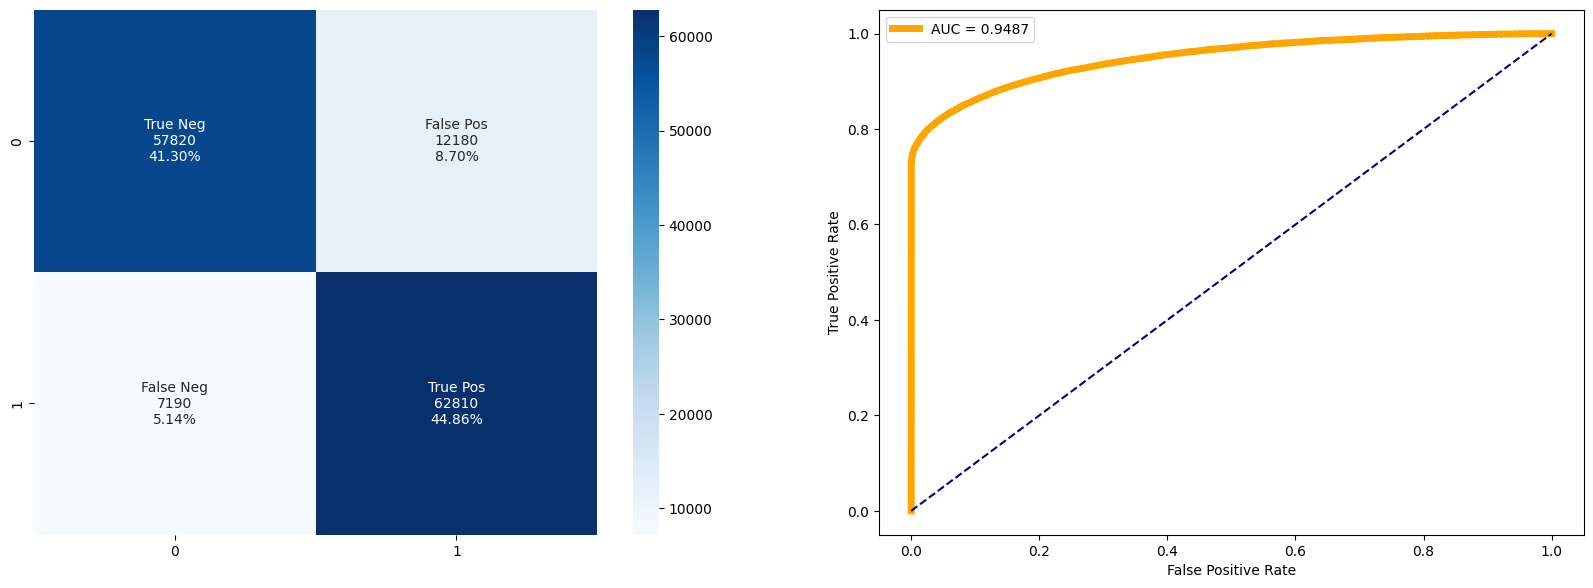


Évaluation sur les données de test :
              precision    recall  f1-score   support

         0.0       0.95      0.82      0.88     84806
         1.0       0.21      0.55      0.30      7448

    accuracy                           0.80     92254
   macro avg       0.58      0.68      0.59     92254
weighted avg       0.89      0.80      0.83     92254


Matrice de confusion et ROC pour les données de test :


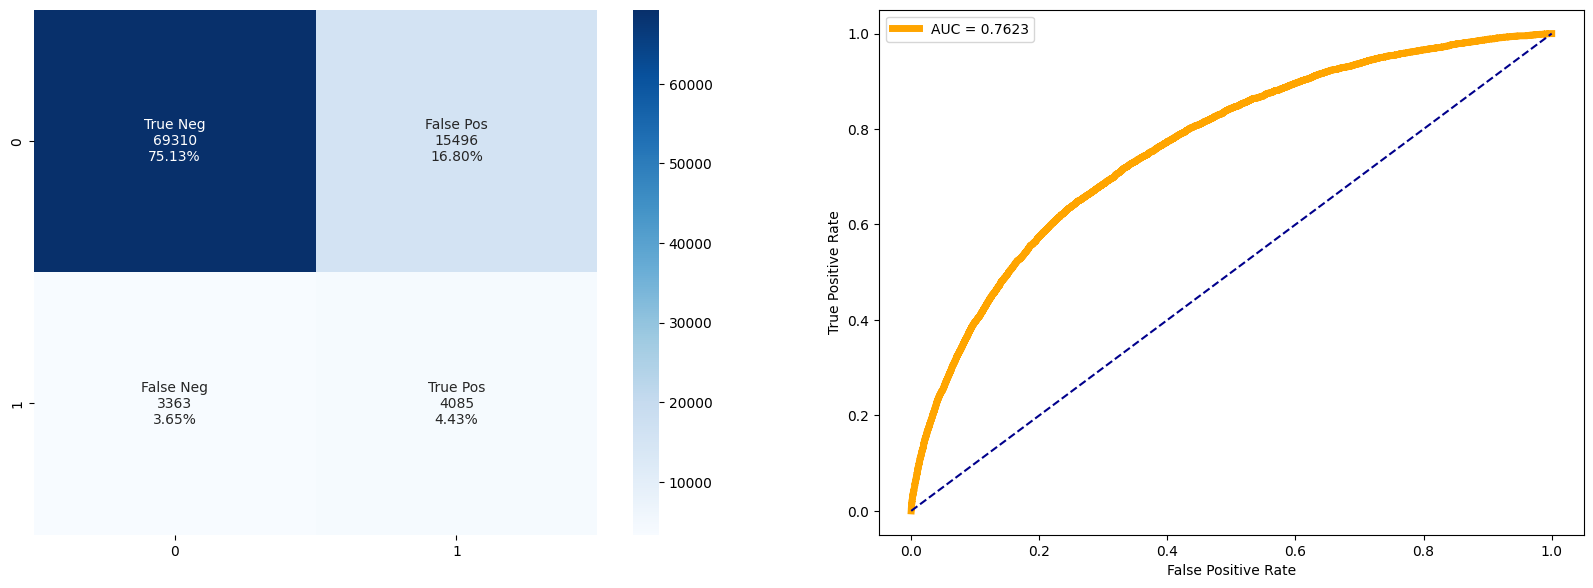

Custom Score: 0.4800


2025/05/04 19:50:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [ ]:
train_model_rfe(LGBMClassifier(),final_data,df_selected, X_train_smote,X_test, y_train_smote,y_test)

In [ ]:
mlflow.end_run()

In [ ]:
def train_models(model, X_train, X_test, y_train, y_test, seuil=0.3):
    # Entraîner le modèle
    model.fit(X_train, y_train)

    # Prédictions pour les données d'entraînement
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_train_pred = (y_train_proba >= seuil).astype(int)

    # Prédictions pour les données de test
    y_test_proba = model.predict_proba(X_test)[:, 1]
    y_test_pred = (y_test_proba >= seuil).astype(int)

    # Calcul des métriques
    output = {
        'AUC_train': roc_auc_score(y_train, y_train_proba),  # Utilisation des probabilités pour l'AUC
        'Accuracy_train': accuracy_score(y_train, y_train_pred),
        'Precision_train': precision_score(y_train, y_train_pred),
        'Recall_train': recall_score(y_train, y_train_pred),
        'F1_train': f1_score(y_train, y_train_pred, average='weighted'),

        'AUC': roc_auc_score(y_test, y_test_proba),  # Utilisation des probabilités pour l'AUC
        'Accuracy': accuracy_score(y_test, y_test_pred),
        'Precision': precision_score(y_test, y_test_pred),
        'Recall': recall_score(y_test, y_test_pred),
        'F1': f1_score(y_test, y_test_pred, average='weighted'),

        'custom_score': custom_score(y_test, y_test_pred)
    }

    return output

In [ ]:
from sklearn import metrics

In [ ]:
import time
import pandas as pd

# Initialisation des listes pour stocker les résultats
name = []
auc_train = []
auc_test = []
accuracy_train = []
accuracy_test = []
precision_train = []
precision_test = []
recall_train = []
recall_test = []
f1_train = []
f1_test = []
custom_scores = []
time_ = []

# Boucle sur chaque modèle pour entraîner et évaluer
for model in models:
    start = time.time()
    results = train_models(model, X_train_smote, X_test, y_train_smote, y_test)

    # Ajouter le nom du modèle
    name.append(type(model).__name__)

    # Récupérer les résultats pour l'ensemble d'entraînement et de test
    # Access dictionary elements directly using keys
    auc_train.append(results['AUC_train'])
    auc_test.append(results['AUC'])

    accuracy_train.append(results['Accuracy_train'])
    accuracy_test.append(results['Accuracy'])

    precision_train.append(results['Precision_train'])
    precision_test.append(results['Precision'])

    recall_train.append(results['Recall_train'])
    recall_test.append(results['Recall'])

    f1_train.append(results['F1_train'])
    f1_test.append(results['F1'])

    custom_scores.append(results['custom_score'])

    # Calculer le temps d'exécution pour chaque modèle
    time_.append(time.time()-start)

# Initialisation du DataFrame avec les résultats collectés
models_rfe = pd.DataFrame(data=[name, auc_train, auc_test, accuracy_train, accuracy_test,
                                precision_train, precision_test, recall_train, recall_test,
                                f1_train, f1_test,custom_scores, time_]).T

models_rfe.columns = ['Model', 'AUC_train', 'AUC_test', 'Accuracy_train', 'Accuracy_test',
                      'Precision_train', 'Precision_test', 'Recall_train', 'Recall_test',
                      'F1_train', 'F1_test','Custom_Score', 'Time']

# Trier les modèles en fonction de l'AUC sur les données de test (en ordre décroissant)
models_rfe.sort_values('AUC_test', ascending=False, inplace=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 70000, number of negative: 70000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14731
[LightGBM] [Info] Number of data points in the train set: 140000, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:50:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:50:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarni

In [ ]:
#Models performance with features selection
models_rfe

,Model,AUC_train,AUC_test,Accuracy_train,Accuracy_test,Precision_train,Precision_test,Recall_train,Recall_test,F1_train,F1_test,Custom_Score,Time
0,CatBoostClassifier,0.949312,0.76696,0.863971,0.798946,0.841309,0.211688,0.897171,0.547127,0.863821,0.835867,0.48,11.262698
1,LGBMClassifier,0.948717,0.762283,0.861643,0.795575,0.837578,0.208621,0.897286,0.548469,0.861467,0.833582,0.48,2.345771
2,XGBClassifier,0.969074,0.758393,0.89615,0.799142,0.875259,0.206639,0.923986,0.524033,0.896069,0.835503,0.46,0.724724


Conclusion: LGBMClassifier reste le modèle le plus performant selon le couple AUC score/Time et le recall

# 8. Hyperparameters tunning - Hyperopt et AUC score

Choisir les hyperparamètres appropriés est nécessaire pour affiner et booster les performances d'un algorithme d’apprentissage automatique. La métrique utilisée dans le contexte de notre classification binaire sera l'AUC score et le custom score.

Grid Search ou Random Search étaient également une alternative possible, à la différence d'Hyperopt une "méthode basique" ne permet pas de traiter un large espace de paramètres, ici très largement privilégié.

Avec Hyperopt, on peut facilement analyser notre modèle de Boosting tout en variant les hyperparamètres dans l'espace que nous allons définir ci-dessous. Hyperopt fonctionne avec les algorithmes de ML distribué, comme Apache Spark MLlib et Horovod, ainsi qu’avec les modèles ML mono-machine, comme scikit-learn et TensorFlow.

In [39]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

In [40]:
#Parameter space
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 600, 100),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.03),
    'max_depth': hp.quniform('max_depth', 3, 7, 1),
    'subsample': hp.uniform('subsample', 0.60, 0.95),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.60, 0.95),
    'reg_lambda': hp.uniform('reg_lambda', 1, 20)
    }

In [42]:
from hyperopt import STATUS_OK
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
import numpy as np

def objective(params, eval_metric='roc_auc', model_type='lgbm'):
    """
    Fonction d'optimisation des hyperparamètres pour LightGBM, XGBoost et CatBoost avec Hyperopt.
    """

    # 🔹 Paramètres communs
    params['n_estimators'] = int(params.get('n_estimators', 100))
    params['max_depth'] = int(params.get('max_depth', 6))
    params['random_state'] = 42

    # 🔹 Initialisation du modèle selon le type
    if model_type == 'lgbm':
        model = LGBMClassifier(
            learning_rate=params['learning_rate'],
            max_depth=params['max_depth'],
            n_estimators=params['n_estimators'],
            subsample=params['subsample'],
            colsample_bytree=params['colsample_bytree'],
            reg_lambda=params['reg_lambda'],
            random_state=42
        )

    elif model_type == 'xgb':
        model = XGBClassifier(
            learning_rate=params['learning_rate'],
            max_depth=params['max_depth'],
            n_estimators=params['n_estimators'],
            subsample=params['subsample'],
            colsample_bytree=params['colsample_bytree'],
            reg_lambda=params['reg_lambda'],
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42
        )

    elif model_type == 'catboost':
        model = CatBoostClassifier(
            learning_rate=params['learning_rate'],
            depth=params['max_depth'],
            iterations=params['n_estimators'],
            l2_leaf_reg=params['reg_lambda'],
            subsample=params['subsample'],
            verbose=0,
            random_state=42
        )

    else:
        raise ValueError(f"Modèle non supporté : {model_type}")

    # 🔹 Validation croisée
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    if eval_metric == 'roc_auc':
        score = cross_val_score(model, X_train_smote, y_train_smote, scoring='roc_auc', cv=cv, n_jobs=-1).mean()
    elif eval_metric == 'custom_score':
        y_pred = cross_val_predict(model, X_train_smote, y_train_smote, cv=cv, n_jobs=-1)
        score = custom_score(y_train_smote, y_pred)
    else:
        raise ValueError("Évaluation non reconnue : choisir 'roc_auc' ou 'custom_score'")

    loss = -score

    return {'loss': loss, 'params': params, 'status': STATUS_OK}


In [43]:
%%time
SEED=1
# Optimisation pour LightGBM
best_lgbm = fmin(
    fn=lambda params: objective(params, model_type='lgbm'),
    space=space,
    algo=tpe.suggest,
    max_evals=30,
    rstate=np.random.default_rng(SEED)
)

100%|██████████| 30/30 [06:15<00:00, 12.50s/trial, best loss: -0.9429941670014778]
CPU times: user 3.2 s, sys: 1.55 s, total: 4.75 s
Wall time: 6min 15s


In [44]:
%%time
SEED=1
# Optimisation pour XGBoost
best_xgb = fmin(
    fn=lambda params: objective(params, model_type='xgb'),
    space=space,
    algo=tpe.suggest,
    max_evals=30,
    rstate=np.random.default_rng(SEED)
)

100%|██████████| 30/30 [06:10<00:00, 12.33s/trial, best loss: -0.9440025882633373]
CPU times: user 3.57 s, sys: 1.3 s, total: 4.87 s
Wall time: 6min 10s


In [45]:
%%time
SEED=1
# Optimisation pour CatBoost
best_catboost = fmin(
    fn=lambda params: objective(params, model_type='catboost'),
    space=space,
    algo=tpe.suggest,
    max_evals=30,
    rstate=np.random.default_rng(SEED)
)

100%|██████████| 30/30 [11:19<00:00, 22.66s/trial, best loss: -0.9413921093796369]
CPU times: user 5.59 s, sys: 2.02 s, total: 7.61 s
Wall time: 11min 19s


In [46]:
mlflow.set_experiment('Optimized_lgbm_hyper')

2025/05/06 10:15:32 INFO mlflow.tracking.fluent: Experiment with name 'Optimized_lgbm_hyper' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/drive/MyDrive/mlflow_logs/143869686864272201', creation_time=1746526532137, experiment_id='143869686864272201', last_update_time=1746526532137, lifecycle_stage='active', name='Optimized_lgbm_hyper', tags={}>

In [47]:
def cf_matrix_roc_auc(model,X_data, y_true, y_pred, y_pred_proba, feature_importances,roc_auc):
    '''This function will make a pretty plot of
  an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    fig = plt.figure(figsize=(20,15))

    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    if feature_importances :
        plt.subplot(212)
        indices = np.argsort(model.feature_importances_)[::-1]

    plt.show()

In [48]:

def train_model_optimized(model, X_data, X_train_smote, X_test, y_train_smote, y_test, seuil=0.2):
    with mlflow.start_run():
        # Entraînement
        trained_model = model.fit(X_train_smote, y_train_smote)

        # Prédictions entraînement
        y_train_proba = trained_model.predict_proba(X_train_smote)[:, 1]
        y_train_pred = (y_train_proba >= seuil).astype(int)

        # Prédictions test
        y_test_proba = trained_model.predict_proba(X_test)[:, 1]
        y_test_pred = (y_test_proba >= seuil).astype(int)

        #  Métriques entraînement
        train_acc = accuracy_score(y_train_smote, y_train_pred)
        train_prec = precision_score(y_train_smote, y_train_pred)
        train_rec = recall_score(y_train_smote, y_train_pred)
        train_auc = roc_auc_score(y_train_smote, y_train_proba)

        #  Métriques test
        test_acc = accuracy_score(y_test, y_test_pred)
        test_prec = precision_score(y_test, y_test_pred)
        test_rec = recall_score(y_test, y_test_pred)
        test_auc = roc_auc_score(y_test, y_test_proba)

        #  Affichage
        print("Évaluation sur les données d'entraînement :")
        print(classification_report(y_train_smote, y_train_pred))

        print("\nMatrice de confusion et ROC pour les données d'entraînement :")
        cf_matrix_roc_auc(
            model=trained_model,
            X_data=X_data,
            y_true=y_train_smote,
            y_pred=y_train_pred,
            y_pred_proba=y_train_proba,
            feature_importances=None,
            roc_auc=train_auc
        )

        print("\nÉvaluation sur les données de test :")
        print(classification_report(y_test, y_test_pred))

        print("\nMatrice de confusion et ROC pour les données de test :")
        cf_matrix_roc_auc(
            model=trained_model,
            X_data=X_data,
            y_true=y_test,
            y_pred=y_test_pred,
            y_pred_proba=y_test_proba,
            feature_importances=None,
            roc_auc=test_auc
        )

        #  Score personnalisé
        custom_score_value = custom_score(y_test, y_test_pred)
        print(f"Custom Score: {custom_score_value:.4f}")

        #  Log modèle
        mlflow.sklearn.log_model(trained_model, "model")

        #  Log métriques dans MLflow
        mlflow.log_metric("train_accuracy", train_acc)
        mlflow.log_metric("train_precision", train_prec)
        mlflow.log_metric("train_recall", train_rec)
        mlflow.log_metric("train_roc_auc", train_auc)

        mlflow.log_metric("test_accuracy", test_acc)
        mlflow.log_metric("test_precision", test_prec)
        mlflow.log_metric("test_recall", test_rec)
        mlflow.log_metric("test_roc_auc", test_auc)

        mlflow.log_metric("custom_score", custom_score_value)




In [49]:
# Création du modèle LightGBM avec les meilleurs hyperparamètres
best_params_lgbm = best_lgbm  # Paramètres optimisés par Hyperopt

model_lgbm = LGBMClassifier(
    learning_rate=best_params_lgbm['learning_rate'],
    max_depth=int(best_params_lgbm['max_depth']),
    n_estimators=int(best_params_lgbm['n_estimators']),
    subsample=best_params_lgbm['subsample'],
    colsample_bytree=best_params_lgbm['colsample_bytree'],
    reg_lambda=best_params_lgbm['reg_lambda'],
    random_state=42
)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 70000, number of negative: 70000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14731
[LightGBM] [Info] Number of data points in the train set: 140000, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Évaluation sur les données d'entraînement :
              precision    recall  f1-score   support

         0.0       0.93      0.69      0.79     70000
         1.0       0.75      0.95      0.84     70000

    accuracy                           0.82    140000
   macro avg       0.84      0.82      0.81    140000
weighted avg       0.84      0.82      0.81    140000


Matrice de confusion et ROC pour les données d'entraînement :


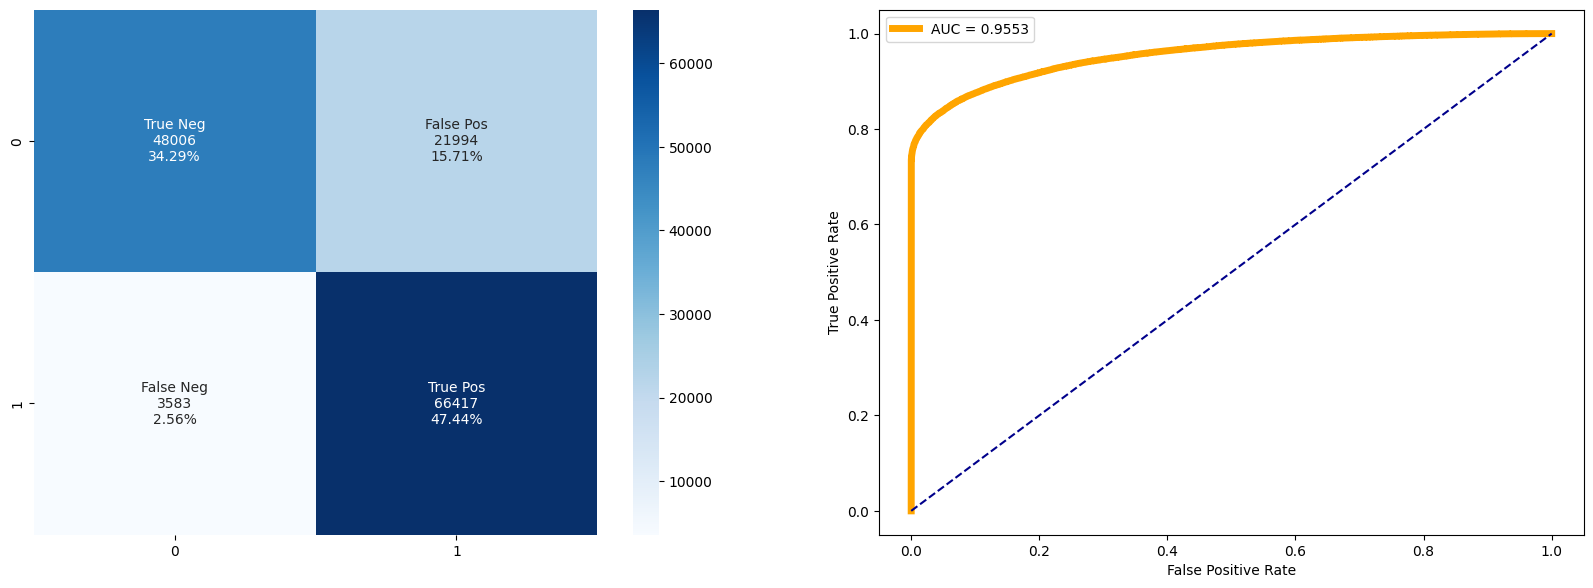


Évaluation sur les données de test :
              precision    recall  f1-score   support

         0.0       0.97      0.67      0.79     84806
         1.0       0.16      0.73      0.27      7448

    accuracy                           0.68     92254
   macro avg       0.56      0.70      0.53     92254
weighted avg       0.90      0.68      0.75     92254


Matrice de confusion et ROC pour les données de test :


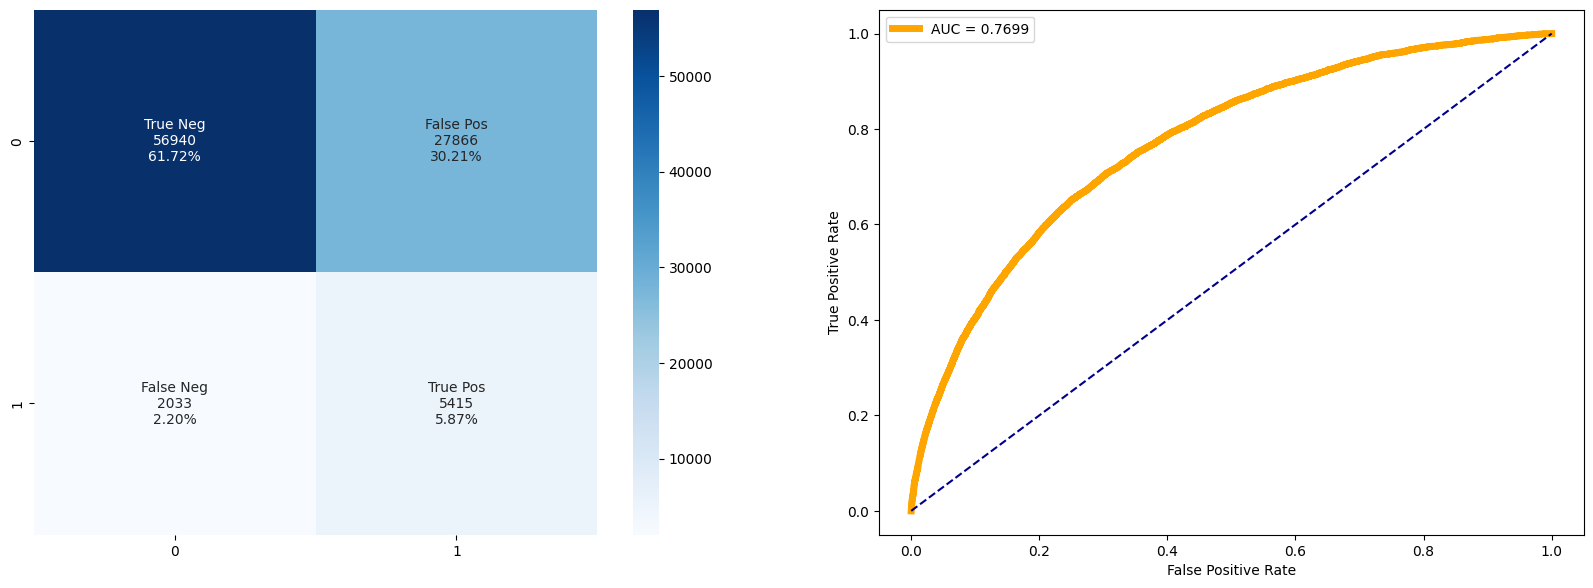

Custom Score: 0.6100


2025/05/06 10:16:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [50]:
train_model_optimized(model_lgbm,df_selected,X_train_smote,X_test,y_train_smote,y_test)

In [51]:
mlflow.set_experiment('Optimized_xgb_hyper')

2025/05/06 10:17:29 INFO mlflow.tracking.fluent: Experiment with name 'Optimized_xgb_hyper' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/drive/MyDrive/mlflow_logs/673744071670575466', creation_time=1746526649921, experiment_id='673744071670575466', last_update_time=1746526649921, lifecycle_stage='active', name='Optimized_xgb_hyper', tags={}>

In [52]:
# Création du modèle XGBoost avec les meilleurs hyperparamètres
best_params = best_xgb  # Paramètres optimisés par Hyperopt

model_xgb = XGBClassifier(
    learning_rate=best_params['learning_rate'],
    max_depth=int(best_params['max_depth']),
    n_estimators=int(best_params['n_estimators']),
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    reg_lambda=best_params['reg_lambda'],
    random_state=42
)

Évaluation sur les données d'entraînement :
              precision    recall  f1-score   support

         0.0       0.95      0.71      0.82     70000
         1.0       0.77      0.97      0.86     70000

    accuracy                           0.84    140000
   macro avg       0.86      0.84      0.84    140000
weighted avg       0.86      0.84      0.84    140000


Matrice de confusion et ROC pour les données d'entraînement :


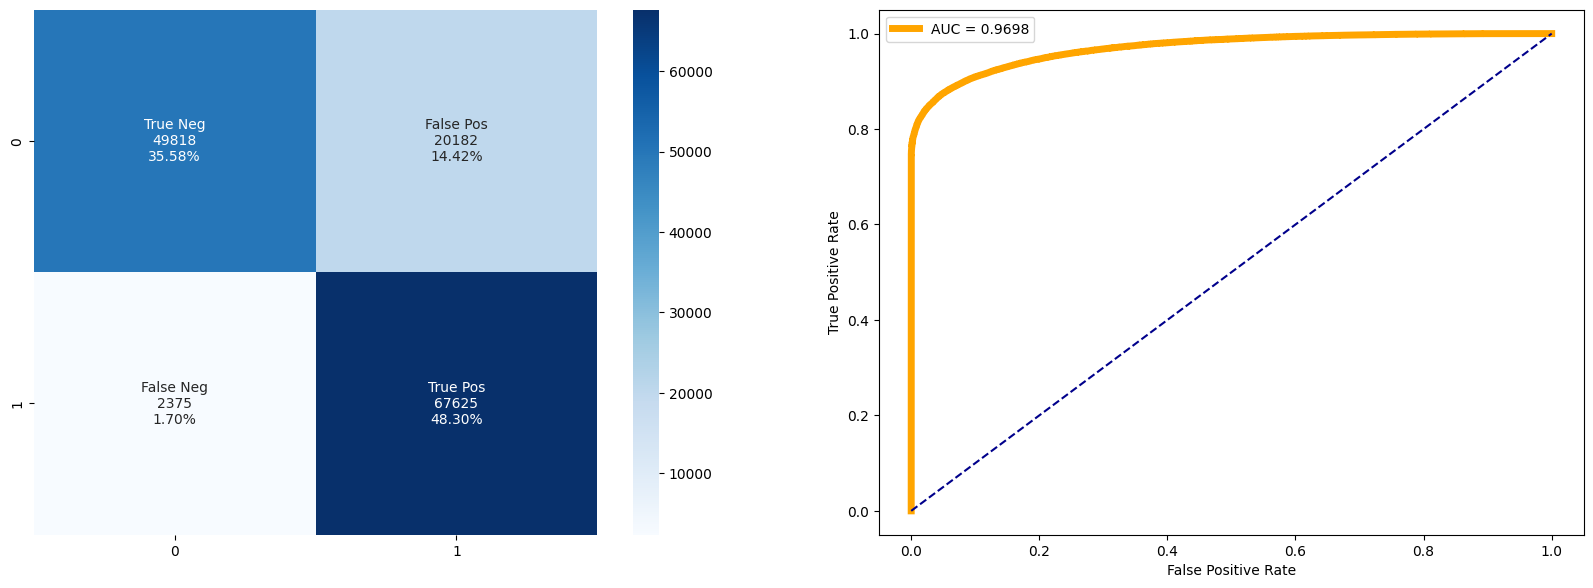


Évaluation sur les données de test :
              precision    recall  f1-score   support

         0.0       0.97      0.67      0.79     84806
         1.0       0.16      0.73      0.27      7448

    accuracy                           0.68     92254
   macro avg       0.56      0.70      0.53     92254
weighted avg       0.90      0.68      0.75     92254


Matrice de confusion et ROC pour les données de test :


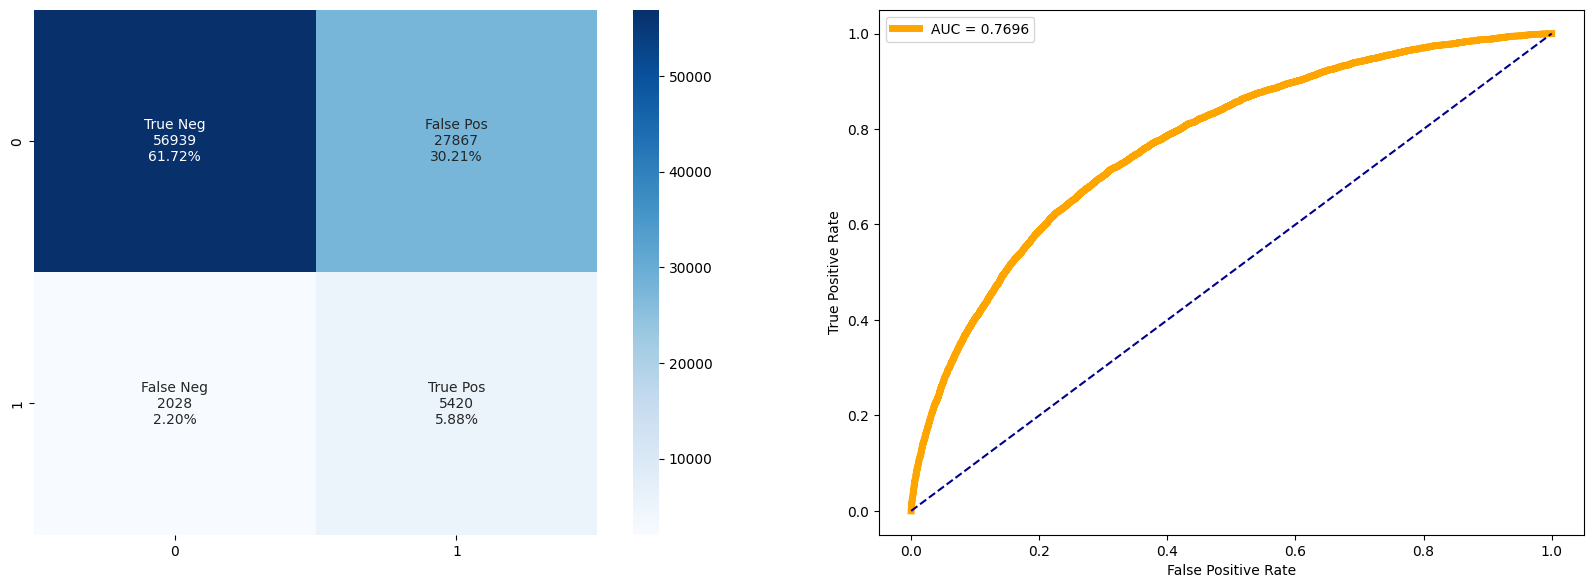

Custom Score: 0.6100


2025/05/06 10:17:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [53]:
train_model_optimized(model_xgb,df_selected,X_train_smote,X_test,y_train_smote,y_test)

In [54]:
mlflow.set_experiment('Optimized_catboost_hyper')

2025/05/06 10:18:21 INFO mlflow.tracking.fluent: Experiment with name 'Optimized_catboost_hyper' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/drive/MyDrive/mlflow_logs/516257843600352377', creation_time=1746526701309, experiment_id='516257843600352377', last_update_time=1746526701309, lifecycle_stage='active', name='Optimized_catboost_hyper', tags={}>

In [55]:
best_params_catboost = best_catboost  # Paramètres optimisés par Hyperopt

model_catboost = CatBoostClassifier(
    learning_rate=best_params_catboost['learning_rate'],
    depth=int(best_params_catboost['max_depth']),
    iterations=int(best_params_catboost['n_estimators']),
    l2_leaf_reg=best_params_catboost['reg_lambda'],
    subsample=best_params_catboost['subsample'],
    verbose=0,
    random_state=42
)

Évaluation sur les données d'entraînement :
              precision    recall  f1-score   support

         0.0       0.92      0.66      0.77     70000
         1.0       0.73      0.95      0.83     70000

    accuracy                           0.80    140000
   macro avg       0.83      0.80      0.80    140000
weighted avg       0.83      0.80      0.80    140000


Matrice de confusion et ROC pour les données d'entraînement :


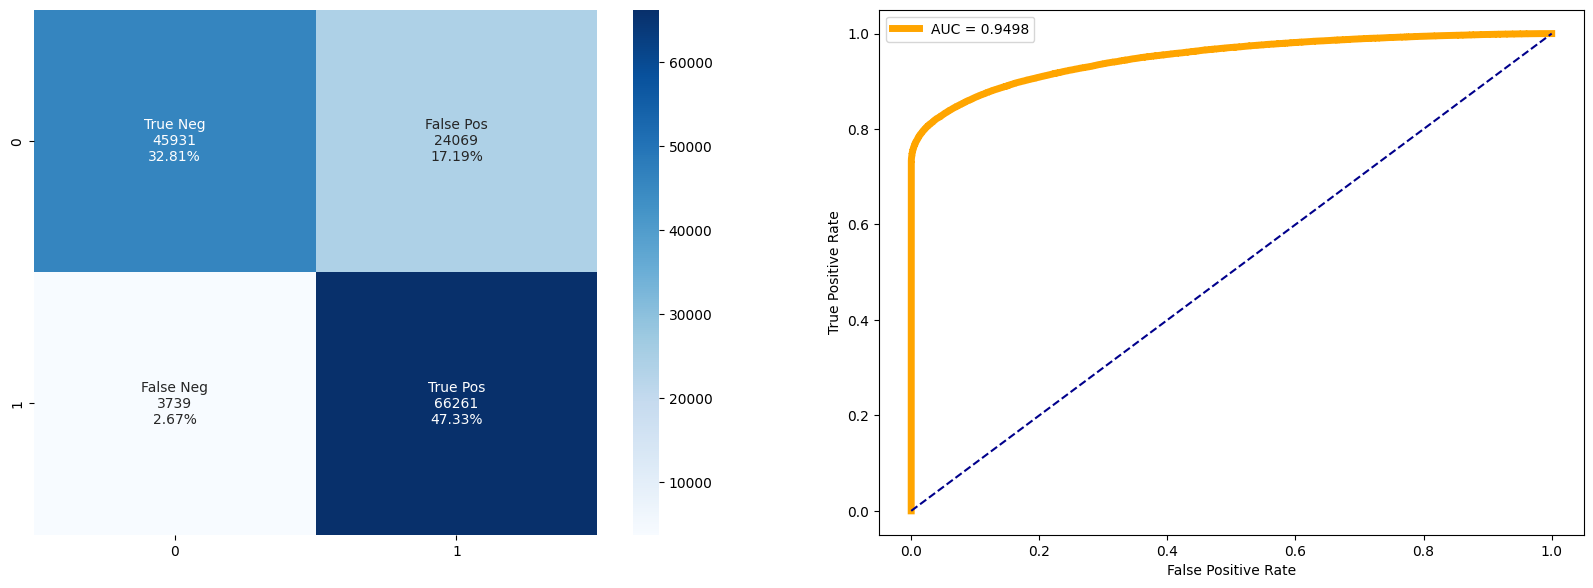


Évaluation sur les données de test :
              precision    recall  f1-score   support

         0.0       0.97      0.65      0.78     84806
         1.0       0.16      0.74      0.26      7448

    accuracy                           0.66     92254
   macro avg       0.56      0.69      0.52     92254
weighted avg       0.90      0.66      0.73     92254


Matrice de confusion et ROC pour les données de test :


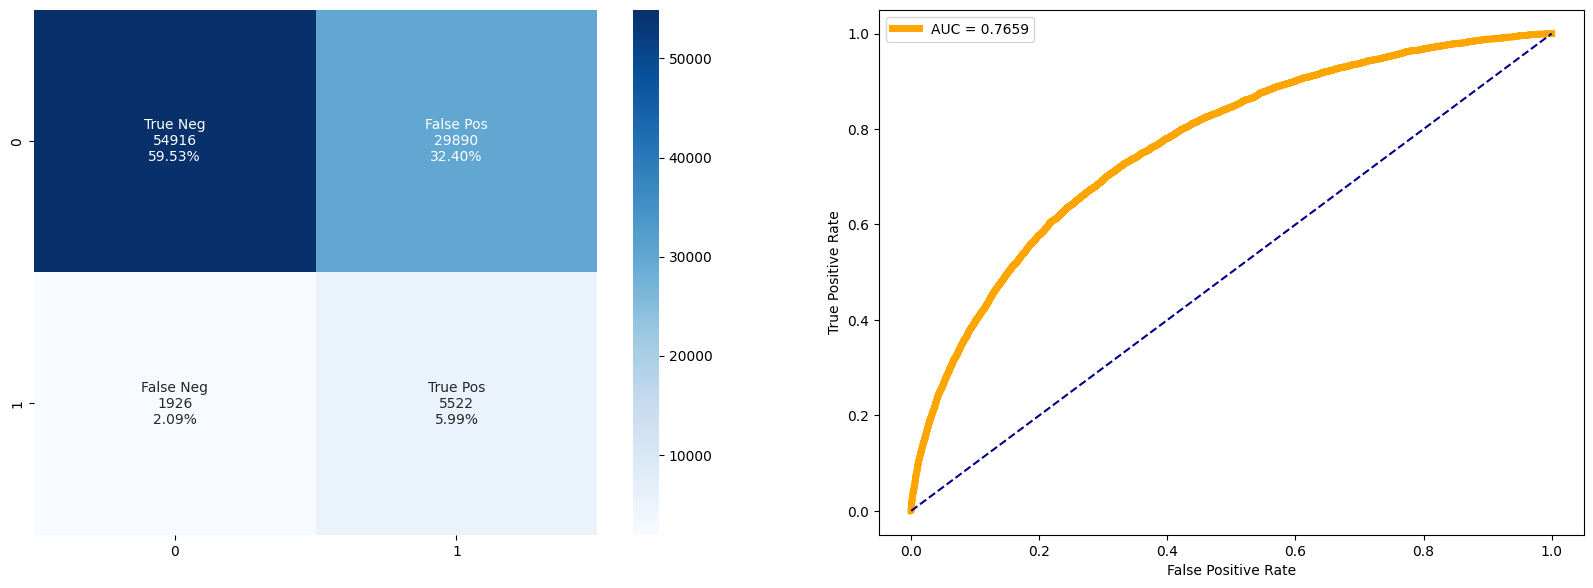

Custom Score: 0.6200


2025/05/06 10:18:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [56]:
train_model_optimized(model_catboost,df_selected,X_train_smote,X_test,y_train_smote,y_test)

In [64]:
def train_models(model, X_train, X_test, y_train, y_test, seuil=0.2):
    # Entraîner le modèle
    model.fit(X_train, y_train)

    # Prédictions pour les données d'entraînement
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_train_pred = (y_train_proba >= seuil).astype(int)

    # Prédictions pour les données de test
    y_test_proba = model.predict_proba(X_test)[:, 1]
    y_test_pred = (y_test_proba >= seuil).astype(int)

    # Calcul des métriques
    output = {
        'AUC_train': roc_auc_score(y_train, y_train_proba),  # Utilisation des probabilités pour l'AUC
        'Accuracy_train': accuracy_score(y_train, y_train_pred),
        'Precision_train': precision_score(y_train, y_train_pred),
        'Recall_train': recall_score(y_train, y_train_pred),
        'F1_train': f1_score(y_train, y_train_pred, average='weighted'),

        'AUC': roc_auc_score(y_test, y_test_proba),  # Utilisation des probabilités pour l'AUC
        'Accuracy': accuracy_score(y_test, y_test_pred),
        'Precision': precision_score(y_test, y_test_pred),
        'Recall': recall_score(y_test, y_test_pred),
        'F1': f1_score(y_test, y_test_pred, average='weighted'),

        'custom_score': custom_score(y_test, y_test_pred)
    }

    return output

In [67]:
import time
import pandas as pd

# Liste de modèles optimisés et leurs noms
models = [model_lgbm, model_xgb, model_catboost]
model_names = ['LightGBM', 'XGBoost', 'CatBoost']

# Initialisation des listes pour stocker les résultats
name = []
auc_train = []
auc_test = []
accuracy_train = []
accuracy_test = []
precision_train = []
precision_test = []
recall_train = []
recall_test = []
f1_train = []
f1_test = []
custom_scores = []
time_ = []

# Boucle sur chaque modèle pour entraîner et évaluer
for model, model_name in zip(models, model_names):
    start = time.time()

    results = train_models(model, X_train_smote, X_test, y_train_smote, y_test)

    # Ajouter les résultats
    name.append(model_name)

    auc_train.append(results['AUC_train'])
    auc_test.append(results['AUC'])

    accuracy_train.append(results['Accuracy_train'])
    accuracy_test.append(results['Accuracy'])

    precision_train.append(results['Precision_train'])
    precision_test.append(results['Precision'])

    recall_train.append(results['Recall_train'])
    recall_test.append(results['Recall'])

    f1_train.append(results['F1_train'])
    f1_test.append(results['F1'])

    custom_scores.append(results['custom_score'])

    time_.append(time.time() - start)

# Création du DataFrame avec les résultats collectés
models_opti = pd.DataFrame({
    'Model': name,
    'AUC_train': auc_train,
    'AUC_test': auc_test,
    'Accuracy_train': accuracy_train,
    'Accuracy_test': accuracy_test,
    'Precision_train': precision_train,
    'Precision_test': precision_test,
    'Recall_train': recall_train,
    'Recall_test': recall_test,
    'F1_train': f1_train,
    'F1_test': f1_test,
    'Custom_Score': custom_scores,
    'Time': time_
})

# Tri par AUC test
models_opti.sort_values('AUC_test', ascending=False, inplace=True)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 70000, number of negative: 70000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14731
[LightGBM] [Info] Number of data points in the train set: 140000, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [68]:
models_opti

,Model,AUC_train,AUC_test,Accuracy_train,Accuracy_test,Precision_train,Precision_test,Recall_train,Recall_test,F1_train,F1_test,Custom_Score,Time
0,LightGBM,0.955291,0.769871,0.817307,0.675906,0.751230,0.162705,0.948814,0.727041,0.814092,0.749571,0.61,7.811763
1,XGBoost,0.969845,0.769584,0.838879,0.675949,0.770155,0.162826,0.966071,0.727712,0.836229,0.749606,0.61,9.095030
2,CatBoost,0.949828,0.765854,0.801371,0.655126,0.733544,0.155936,0.946586,0.741407,0.797093,0.733590,0.62,18.229031


LightGBM offre le meilleur équilibre entre performance (AUC test = 0.77), rappel élevé (0.73) et rapidité d’exécution (7.8 s). Il se montre particulièrement adapté aux jeux de données déséquilibrés et est recommandé comme modèle final pour ce projet.

In [ ]:
%%time

import pickle

# Création du modèle LGBM avec les meilleurs hyperparamètres
lgbm = LGBMClassifier(
    n_estimators=int(best['n_estimators']),
    colsample_bytree= best['colsample_bytree'],
    learning_rate= best['learning_rate'],
    max_depth= int(best['max_depth']),
    subsample= best['subsample'],
    reg_lambda= best['reg_lambda']
)

# Entraînement du modèle
lgbm.fit(X_train_smote, y_train_smote)

# Spécifier le chemin de sauvegarde sur Google Drive
file_path = "/content/drive/MyDrive/models/LGBMClassifier1.pkl"

# Sauvegarder le modèle sur Google Drive
with open(file_path, "wb") as file:
    pickle.dump(lgbm, file)

print("Modèle sauvegardé sur Google Drive !")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 70000, number of negative: 70000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14731
[LightGBM] [Info] Number of data points in the train set: 140000, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Modèle sauvegardé sur Google Drive !
CPU times: user 41.1 s, sys: 47.1 ms, total: 41.2 s
Wall time: 7.07 s


In [ ]:
roc_auc = roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1])
print('AUC : %0.6f' %roc_auc)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


AUC : 0.768739


In [ ]:
#Check list features importance
sorted_idx = np.argsort(lgbm.feature_importances_)[::-1]
for index in sorted_idx:
    print([df_selected.columns[index], lgbm.feature_importances_[index]])

['CREDIT_TERM', np.int32(984)]
['AMT_REQ_CREDIT_BUREAU_YEAR', np.int32(936)]
['EXT_SOURCE_3', np.int32(732)]
['PREVIOUS_LOANS_COUNT', np.int32(732)]
['EXT_SOURCE_1', np.int32(623)]
['EXT_SOURCE_2', np.int32(600)]
['HOUR_APPR_PROCESS_START', np.int32(554)]
['DAYS_BIRTH', np.int32(479)]
['PREV_APPL_MEAN_CNT_PAYMENT', np.int32(475)]
['OBS_30_CNT_SOCIAL_CIRCLE', np.int32(449)]
['AMT_GOODS_PRICE', np.int32(439)]
['AMT_INCOME_TOTAL', np.int32(409)]
['OBS_60_CNT_SOCIAL_CIRCLE', np.int32(403)]
['PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT', np.int32(387)]
['CNT_CHILDREN', np.int32(385)]
['PREVIOUS_APPLICATION_COUNT', np.int32(380)]
['REGION_POPULATION_RELATIVE', np.int32(342)]
['PREV_APPL_MEAN_AMT_DOWN_PAYMENT', np.int32(338)]
['PREV_BUR_MEAN_AMT_CREDIT_SUM', np.int32(336)]
['PREV_APPL_MEAN_DAYS_LAST_DUE_1ST_VERSION', np.int32(331)]
['PREV_APPL_MEAN_INSTALL_MEAN_AMT_PAYMENT', np.int32(330)]
['AMT_REQ_CREDIT_BUREAU_QRT', np.int32(316)]
['AMT_ANNUITY', np.int32(312)]
['DAYS_ID_PUBLISH', np.int32(307)]
['P

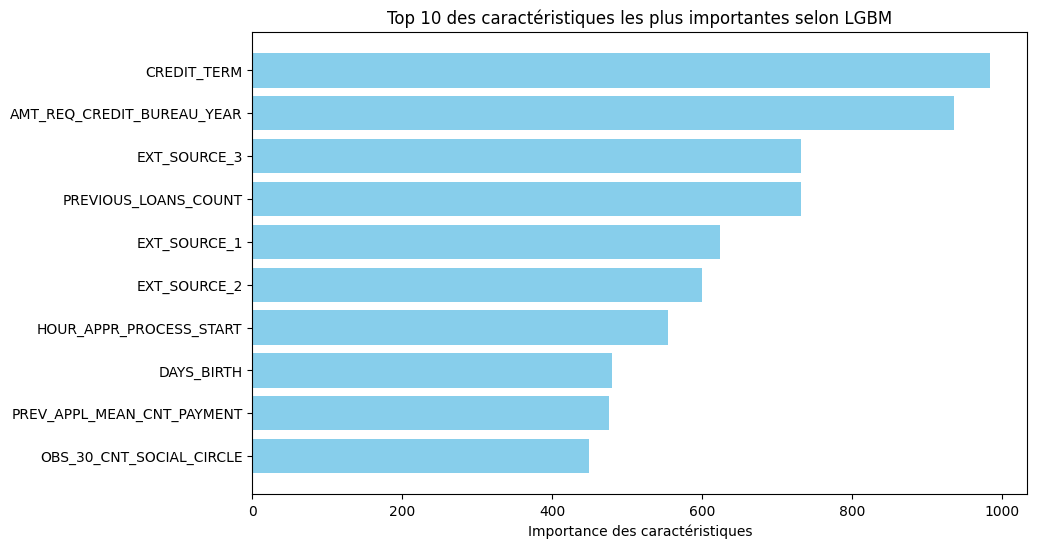

CREDIT_TERM: 984
AMT_REQ_CREDIT_BUREAU_YEAR: 936
EXT_SOURCE_3: 732
PREVIOUS_LOANS_COUNT: 732
EXT_SOURCE_1: 623
EXT_SOURCE_2: 600
HOUR_APPR_PROCESS_START: 554
DAYS_BIRTH: 479
PREV_APPL_MEAN_CNT_PAYMENT: 475
OBS_30_CNT_SOCIAL_CIRCLE: 449


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Tri des indices des caractéristiques selon leur importance
sorted_idx = np.argsort(lgbm.feature_importances_)[::-1]

# Sélection des 10 premières caractéristiques les plus importantes
top_10_idx = sorted_idx[:10]
top_10_importances = lgbm.feature_importances_[top_10_idx]
top_10_features = df_selected.columns[top_10_idx]

# Graphique des 10 caractéristiques les plus importantes
plt.figure(figsize=(10, 6))
plt.barh(top_10_features, top_10_importances, align="center", color='skyblue')
plt.xlabel("Importance des caractéristiques")
plt.title("Top 10 des caractéristiques les plus importantes selon LGBM")
plt.gca().invert_yaxis()  # Inverser l'axe y pour afficher la caractéristique la plus importante en haut
plt.show()

# Afficher les caractéristiques et leurs importances dans la console
for feature, importance in zip(top_10_features, top_10_importances):
    print(f"{feature}: {importance}")


In [ ]:
!pip install shap

In [ ]:
import shap

In [ ]:
explainer= shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(df_selected.drop(columns=['TARGET']))

/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


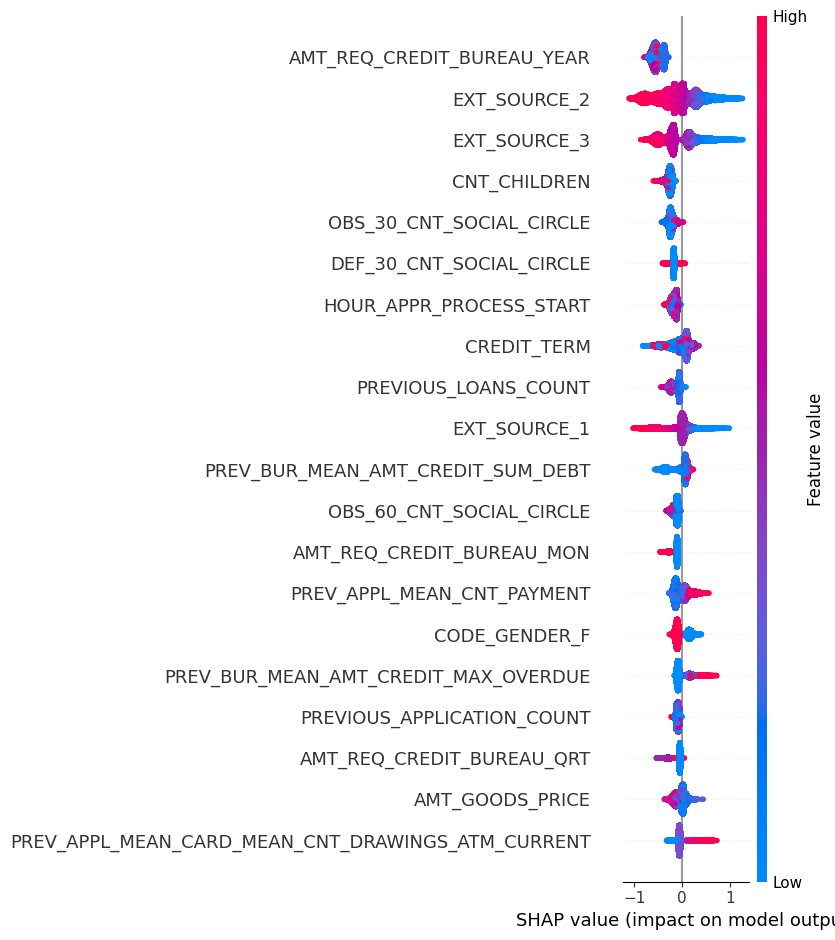

In [ ]:
shap.summary_plot(shap_values, df_selected.drop(columns=['TARGET']))

In [ ]:
explainer = shap.TreeExplainer(lgbm, df_selected.drop(columns=['TARGET']))

<Axes: xlabel='SHAP value'>

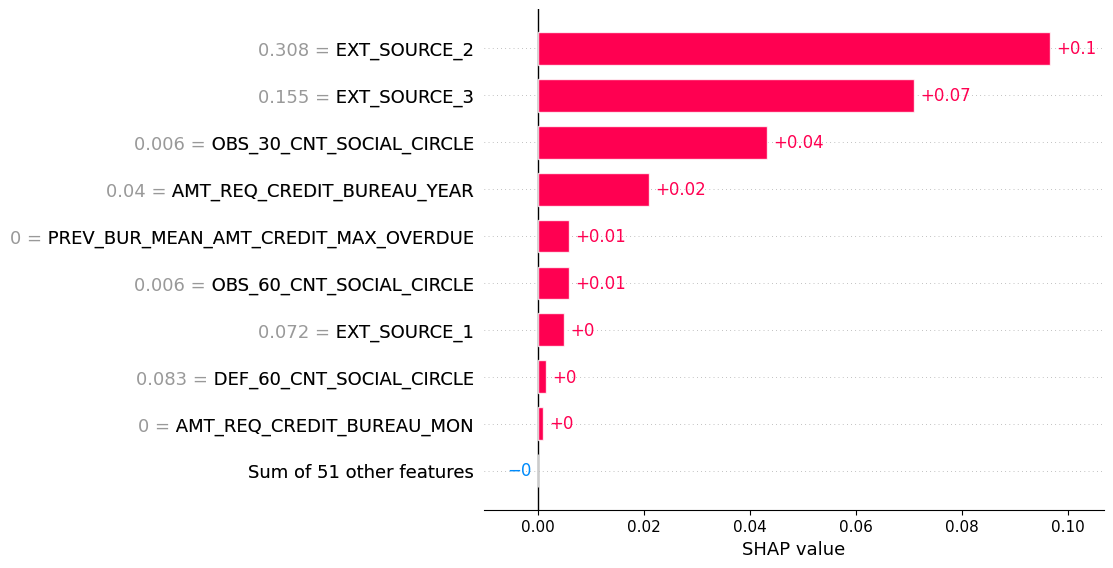

In [ ]:
shap_values = explainer(df_selected.drop(columns=['TARGET']).iloc[[0]], check_additivity=False)
shap.plots.bar(shap_values[0], show=False)